In [1]:
import torch

# torch.where(grad_norm > self.cfg.optimization.clip_norm, grad_norm.new_tensor(100), grad_norm.new_tensor(0))

In [16]:
!python $FAIRSEQ_ROOT/examples/hubert/simple_kmeans/dump_mfcc_feature.py ~/data/fairseqProcessed/LibriSpeech-no-silence train 1 0 ~/data/fairseqProcessed/LibriSpeech-no-silence/mfcc

2023-04-16 09:46:54.844099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 09:46:58.578789: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/lmod/mpi/libfabric/1.17.1/lib:/opt/ohpc/pub/mpi/ucx-ohpc/1.11.2/lib:/opt/ohpc/pub/libs/hwloc/lib:/opt/ohpc/pub/mpi/openmpi4-gnu9/4.1.1/lib:/opt/ohpc/pub/compiler/gcc/9.4.0/lib64
2023-04-16 09:46:58.578904: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared obje

In [17]:
!python $FAIRSEQ_ROOT/examples/hubert/simple_kmeans/learn_kmeans.py ~/data/fairseqProcessed/LibriSpeech-no-silence/mfcc train 1 ~/data/fairseqProcessed/LibriSpeech-no-silence/mfcc/cls64 64

2023-04-16 10:34:37 | INFO | root | Namespace(feat_dir='/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/mfcc', split='train', nshard=1, km_path='/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/mfcc/cls64', n_clusters=64, seed=0, percent=-1, init='k-means++', max_iter=100, batch_size=10000, tol=0.0, max_no_improvement=100, n_init=20, reassignment_ratio=0.0)
2023-04-16 10:38:11 | INFO | root | loaded feature with dimension (30637406, 39)
Init 1/20 with method k-means++
Inertia for init 1/20: 66779576.0
Init 2/20 with method k-means++
Inertia for init 2/20: 67476560.0
Init 3/20 with method k-means++
Inertia for init 3/20: 67591504.0
Init 4/20 with method k-means++
Inertia for init 4/20: 67565184.0
Init 5/20 with method k-means++
Inertia for init 5/20: 67670960.0
Init 6/20 with method k-means++
Inertia for init 6/20: 68239376.0
Init 7/20 with method k-means++
Inertia for init 7/20: 68240496.0
Init 8/20 with method k-means++
Inertia for init 8/20: 68476

Minibatch step 76/306374: mean batch inertia: 1785.096, ewa inertia: 1883.7134171486482
Minibatch step 77/306374: mean batch inertia: 1777.3312, ewa inertia: 1883.6439711820567
Minibatch step 78/306374: mean batch inertia: 1779.8572, ewa inertia: 1883.5762195141808
Minibatch step 79/306374: mean batch inertia: 1787.9732, ewa inertia: 1883.5138101728717
Minibatch step 80/306374: mean batch inertia: 1788.3534, ewa inertia: 1883.4516897655062
Minibatch step 81/306374: mean batch inertia: 1782.3754, ewa inertia: 1883.3857074911148
Minibatch step 82/306374: mean batch inertia: 1798.9832, ewa inertia: 1883.3306098077558
Minibatch step 83/306374: mean batch inertia: 1780.2964, ewa inertia: 1883.2633494095062
Minibatch step 84/306374: mean batch inertia: 1799.1174, ewa inertia: 1883.2084192064315
Minibatch step 85/306374: mean batch inertia: 1802.3584, ewa inertia: 1883.1556405759118
Minibatch step 86/306374: mean batch inertia: 1783.2172, ewa inertia: 1883.090401085784
Minibatch step 87/30637

Minibatch step 172/306374: mean batch inertia: 1799.2576, ewa inertia: 1877.8354177236745
Minibatch step 173/306374: mean batch inertia: 1794.5156, ewa inertia: 1877.7810268166868
Minibatch step 174/306374: mean batch inertia: 1788.7062, ewa inertia: 1877.7228790584143
Minibatch step 175/306374: mean batch inertia: 1796.8928, ewa inertia: 1877.6701134447587
Minibatch step 176/306374: mean batch inertia: 1787.0492, ewa inertia: 1877.610956406146
Minibatch step 177/306374: mean batch inertia: 1787.5864, ewa inertia: 1877.552188667475
Minibatch step 178/306374: mean batch inertia: 1790.1172, ewa inertia: 1877.4951113902318
Minibatch step 179/306374: mean batch inertia: 1783.7496, ewa inertia: 1877.4339146242062
Minibatch step 180/306374: mean batch inertia: 1780.437, ewa inertia: 1877.3705953526867
Minibatch step 181/306374: mean batch inertia: 1789.9062, ewa inertia: 1877.3134988788547
Minibatch step 182/306374: mean batch inertia: 1777.1126, ewa inertia: 1877.248088056797
Minibatch step

Minibatch step 267/306374: mean batch inertia: 1811.9368, ewa inertia: 1872.2592193097084
Minibatch step 268/306374: mean batch inertia: 1796.8022, ewa inertia: 1872.209961212044
Minibatch step 269/306374: mean batch inertia: 1794.2662, ewa inertia: 1872.1590797773245
Minibatch step 270/306374: mean batch inertia: 1790.226, ewa inertia: 1872.1055941283742
Minibatch step 271/306374: mean batch inertia: 1779.5532, ewa inertia: 1872.0451762254304
Minibatch step 272/306374: mean batch inertia: 1785.2744, ewa inertia: 1871.9885325439168
Minibatch step 273/306374: mean batch inertia: 1781.769, ewa inertia: 1871.9296375254553
Minibatch step 274/306374: mean batch inertia: 1766.4228, ewa inertia: 1871.8607630038448
Minibatch step 275/306374: mean batch inertia: 1793.1572, ewa inertia: 1871.8093855729778
Minibatch step 276/306374: mean batch inertia: 1785.6184, ewa inertia: 1871.753120376923
Minibatch step 277/306374: mean batch inertia: 1769.023, ewa inertia: 1871.6860584872682
Minibatch step 

Minibatch step 359/306374: mean batch inertia: 1788.9108, ewa inertia: 1867.0838474089642
Minibatch step 360/306374: mean batch inertia: 1777.67, ewa inertia: 1867.0254783391476
Minibatch step 361/306374: mean batch inertia: 1788.2284, ewa inertia: 1866.974039861773
Minibatch step 362/306374: mean batch inertia: 1775.0624, ewa inertia: 1866.914040241138
Minibatch step 363/306374: mean batch inertia: 1777.379, ewa inertia: 1866.8555920570334
Minibatch step 364/306374: mean batch inertia: 1772.2248, ewa inertia: 1866.7938173826576
Minibatch step 365/306374: mean batch inertia: 1788.96, ewa inertia: 1866.7430077189138
Minibatch step 366/306374: mean batch inertia: 1782.9066, ewa inertia: 1866.6882795836514
Minibatch step 367/306374: mean batch inertia: 1768.9756, ewa inertia: 1866.624493063086
Minibatch step 368/306374: mean batch inertia: 1778.1398, ewa inertia: 1866.566730542215
Minibatch step 369/306374: mean batch inertia: 1773.9, ewa inertia: 1866.506238000831
Minibatch step 370/3063

Minibatch step 453/306374: mean batch inertia: 1784.6988, ewa inertia: 1862.119550391795
Minibatch step 454/306374: mean batch inertia: 1790.5368, ewa inertia: 1862.0728214043243
Minibatch step 455/306374: mean batch inertia: 1776.176, ewa inertia: 1862.0167482376855
Minibatch step 456/306374: mean batch inertia: 1773.706, ewa inertia: 1861.959099267433
Minibatch step 457/306374: mean batch inertia: 1789.8076, ewa inertia: 1861.9119990025395
Minibatch step 458/306374: mean batch inertia: 1782.0742, ewa inertia: 1861.8598811460886
Minibatch step 459/306374: mean batch inertia: 1788.8476, ewa inertia: 1861.8122189655744
Minibatch step 460/306374: mean batch inertia: 1776.0148, ewa inertia: 1861.7562106885255
Minibatch step 461/306374: mean batch inertia: 1789.922, ewa inertia: 1861.709317548588
Minibatch step 462/306374: mean batch inertia: 1765.6516, ewa inertia: 1861.6466113818756
Minibatch step 463/306374: mean batch inertia: 1771.0368, ewa inertia: 1861.5874615906532
Minibatch step 4

Minibatch step 546/306374: mean batch inertia: 1768.45, ewa inertia: 1857.3747542122378
Minibatch step 547/306374: mean batch inertia: 1778.0592, ewa inertia: 1857.3229772754935
Minibatch step 548/306374: mean batch inertia: 1772.9652, ewa inertia: 1857.2679087918743
Minibatch step 549/306374: mean batch inertia: 1782.4392, ewa inertia: 1857.2190608532794
Minibatch step 550/306374: mean batch inertia: 1783.4836, ewa inertia: 1857.1709265833958
Minibatch step 551/306374: mean batch inertia: 1791.678, ewa inertia: 1857.1281730131714
Minibatch step 552/306374: mean batch inertia: 1786.324, ewa inertia: 1857.08195227849
Minibatch step 553/306374: mean batch inertia: 1776.8444, ewa inertia: 1857.0295734643962
Minibatch step 554/306374: mean batch inertia: 1785.3442, ewa inertia: 1856.9827774849161
Minibatch step 555/306374: mean batch inertia: 1799.9116, ewa inertia: 1856.94552160521
Minibatch step 556/306374: mean batch inertia: 1782.643, ewa inertia: 1856.8970171599053
Minibatch step 557/

Minibatch step 641/306374: mean batch inertia: 1772.7272, ewa inertia: 1852.732911174078
Minibatch step 642/306374: mean batch inertia: 1780.7998, ewa inertia: 1852.6859534722241
Minibatch step 643/306374: mean batch inertia: 1792.664, ewa inertia: 1852.6467713355162
Minibatch step 644/306374: mean batch inertia: 1777.0788, ewa inertia: 1852.5974408087286
Minibatch step 645/306374: mean batch inertia: 1777.169, ewa inertia: 1852.5482013670169
Minibatch step 646/306374: mean batch inertia: 1778.3746, ewa inertia: 1852.499781080426
Minibatch step 647/306374: mean batch inertia: 1771.2878, ewa inertia: 1852.446766162368
Minibatch step 648/306374: mean batch inertia: 1798.0644, ewa inertia: 1852.4112655299793
Minibatch step 649/306374: mean batch inertia: 1783.7436, ewa inertia: 1852.3664395004591
Minibatch step 650/306374: mean batch inertia: 1777.0356, ewa inertia: 1852.317263772565
Minibatch step 651/306374: mean batch inertia: 1791.3188, ewa inertia: 1852.2774441730976
Minibatch step 6

Minibatch step 734/306374: mean batch inertia: 1786.4538, ewa inertia: 1848.5950843500864
Minibatch step 735/306374: mean batch inertia: 1785.6588, ewa inertia: 1848.5539997476262
Minibatch step 736/306374: mean batch inertia: 1797.9364, ewa inertia: 1848.5209567425522
Minibatch step 737/306374: mean batch inertia: 1765.9424, ewa inertia: 1848.467049728331
Minibatch step 738/306374: mean batch inertia: 1780.3888, ewa inertia: 1848.422608467536
Minibatch step 739/306374: mean batch inertia: 1783.257, ewa inertia: 1848.3800685695167
Minibatch step 740/306374: mean batch inertia: 1781.8432, ewa inertia: 1848.3366335173466
Minibatch step 741/306374: mean batch inertia: 1775.174, ewa inertia: 1848.2888731872915
Minibatch step 742/306374: mean batch inertia: 1779.3826, ewa inertia: 1848.2438913954659
Minibatch step 743/306374: mean batch inertia: 1801.0214, ewa inertia: 1848.2130647061213
Minibatch step 744/306374: mean batch inertia: 1782.3236, ewa inertia: 1848.1700522770952
Minibatch step

Minibatch step 826/306374: mean batch inertia: 1769.9852, ewa inertia: 1844.5745209548973
Minibatch step 827/306374: mean batch inertia: 1770.5488, ewa inertia: 1844.52619720416
Minibatch step 828/306374: mean batch inertia: 1776.2298, ewa inertia: 1844.4816135373999
Minibatch step 829/306374: mean batch inertia: 1774.0852, ewa inertia: 1844.4356589867832
Minibatch step 830/306374: mean batch inertia: 1772.1424, ewa inertia: 1844.3884661816041
Minibatch step 831/306374: mean batch inertia: 1767.5054, ewa inertia: 1844.3382771651632
Minibatch step 832/306374: mean batch inertia: 1779.1644, ewa inertia: 1844.2957318693648
Minibatch step 833/306374: mean batch inertia: 1782.4224, ewa inertia: 1844.2553411588392
Minibatch step 834/306374: mean batch inertia: 1769.6948, ewa inertia: 1844.2066682792063
Minibatch step 835/306374: mean batch inertia: 1775.7454, ewa inertia: 1844.1619769851425
Minibatch step 836/306374: mean batch inertia: 1790.1044, ewa inertia: 1844.1266883740761
Minibatch st

Minibatch step 918/306374: mean batch inertia: 1791.7788, ewa inertia: 1840.7310221046455
Minibatch step 919/306374: mean batch inertia: 1779.1268, ewa inertia: 1840.6908070681022
Minibatch step 920/306374: mean batch inertia: 1762.3508, ewa inertia: 1840.639666965372
Minibatch step 921/306374: mean batch inertia: 1793.6902, ewa inertia: 1840.6090185054907
Minibatch step 922/306374: mean batch inertia: 1766.504, ewa inertia: 1840.5606429895695
Minibatch step 923/306374: mean batch inertia: 1792.2222, ewa inertia: 1840.5290878106407
Minibatch step 924/306374: mean batch inertia: 1776.091, ewa inertia: 1840.4870228357486
Minibatch step 925/306374: mean batch inertia: 1794.9706, ewa inertia: 1840.4573098624307
Minibatch step 926/306374: mean batch inertia: 1786.7958, ewa inertia: 1840.4222798026985
Minibatch step 927/306374: mean batch inertia: 1769.9092, ewa inertia: 1840.3762490927218
Minibatch step 928/306374: mean batch inertia: 1788.978, ewa inertia: 1840.3426964822852
Minibatch step

Minibatch step 1011/306374: mean batch inertia: 1762.2664, ewa inertia: 1837.1284535114785
Minibatch step 1012/306374: mean batch inertia: 1778.4266, ewa inertia: 1837.0901331317468
Minibatch step 1013/306374: mean batch inertia: 1765.0076, ewa inertia: 1837.0430778877233
Minibatch step 1014/306374: mean batch inertia: 1786.878, ewa inertia: 1837.010330287453
Minibatch step 1015/306374: mean batch inertia: 1791.8492, ewa inertia: 1836.9808492479592
Minibatch step 1016/306374: mean batch inertia: 1783.1336, ewa inertia: 1836.945697938158
Minibatch step 1017/306374: mean batch inertia: 1792.0506, ewa inertia: 1836.9163905637197
Minibatch step 1018/306374: mean batch inertia: 1766.1184, ewa inertia: 1836.8701738649215
Minibatch step 1019/306374: mean batch inertia: 1780.64, ewa inertia: 1836.833466989653
Minibatch step 1020/306374: mean batch inertia: 1783.0612, ewa inertia: 1836.7983646280272
Minibatch step 1021/306374: mean batch inertia: 1778.5284, ewa inertia: 1836.760326183959
Miniba

Minibatch step 1103/306374: mean batch inertia: 1787.6636, ewa inertia: 1833.824003503298
Minibatch step 1104/306374: mean batch inertia: 1784.9904, ewa inertia: 1833.7921250851905
Minibatch step 1105/306374: mean batch inertia: 1791.9004, ewa inertia: 1833.7647783028171
Minibatch step 1106/306374: mean batch inertia: 1788.9222, ewa inertia: 1833.7355052130267
Minibatch step 1107/306374: mean batch inertia: 1763.7188, ewa inertia: 1833.6897985347734
Minibatch step 1108/306374: mean batch inertia: 1777.1012, ewa inertia: 1833.652857681042
Minibatch step 1109/306374: mean batch inertia: 1782.493, ewa inertia: 1833.6194606917463
Minibatch step 1110/306374: mean batch inertia: 1786.5664, ewa inertia: 1833.588744606216
Minibatch step 1111/306374: mean batch inertia: 1783.556, ewa inertia: 1833.5560833926831
Minibatch step 1112/306374: mean batch inertia: 1771.2404, ewa inertia: 1833.5154039165168
Minibatch step 1113/306374: mean batch inertia: 1774.8848, ewa inertia: 1833.4771300482898
Mini

Minibatch step 1194/306374: mean batch inertia: 1786.4854, ewa inertia: 1830.7093926466268
Minibatch step 1195/306374: mean batch inertia: 1773.7686, ewa inertia: 1830.6722218817206
Minibatch step 1196/306374: mean batch inertia: 1778.1212, ewa inertia: 1830.6379167449434
Minibatch step 1197/306374: mean batch inertia: 1796.7064, ewa inertia: 1830.6157663607773
Minibatch step 1198/306374: mean batch inertia: 1764.2756, ewa inertia: 1830.572459715172
Minibatch step 1199/306374: mean batch inertia: 1782.7892, ewa inertia: 1830.5412669580855
Minibatch step 1200/306374: mean batch inertia: 1797.2808, ewa inertia: 1830.5195546330456
Minibatch step 1201/306374: mean batch inertia: 1778.364, ewa inertia: 1830.4855076560066
Minibatch step 1202/306374: mean batch inertia: 1775.8464, ewa inertia: 1830.4498394236027
Minibatch step 1203/306374: mean batch inertia: 1774.6868, ewa inertia: 1830.4134374921837
Minibatch step 1204/306374: mean batch inertia: 1775.8448, ewa inertia: 1830.3778152624745
M

Minibatch step 1285/306374: mean batch inertia: 1781.0284, ewa inertia: 1827.751095708568
Minibatch step 1286/306374: mean batch inertia: 1768.6166, ewa inertia: 1827.7124929014121
Minibatch step 1287/306374: mean batch inertia: 1769.9706, ewa inertia: 1827.6747991808556
Minibatch step 1288/306374: mean batch inertia: 1765.0648, ewa inertia: 1827.6339275762966
Minibatch step 1289/306374: mean batch inertia: 1778.2106, ewa inertia: 1827.6016641882256
Minibatch step 1290/306374: mean batch inertia: 1764.0168, ewa inertia: 1827.560156194949
Minibatch step 1291/306374: mean batch inertia: 1796.9888, ewa inertia: 1827.5401993127005
Minibatch step 1292/306374: mean batch inertia: 1767.506, ewa inertia: 1827.5010091819477
Minibatch step 1293/306374: mean batch inertia: 1782.4912, ewa inertia: 1827.471626924381
Minibatch step 1294/306374: mean batch inertia: 1774.5602, ewa inertia: 1827.4370865163598
Minibatch step 1295/306374: mean batch inertia: 1767.6506, ewa inertia: 1827.3980580917178
Min

Minibatch step 1377/306374: mean batch inertia: 1787.9546, ewa inertia: 1824.8988244018149
Minibatch step 1378/306374: mean batch inertia: 1792.1108, ewa inertia: 1824.8774204857446
Minibatch step 1379/306374: mean batch inertia: 1771.9896, ewa inertia: 1824.84289548793
Minibatch step 1380/306374: mean batch inertia: 1774.7332, ewa inertia: 1824.810184041111
Minibatch step 1381/306374: mean batch inertia: 1776.9482, ewa inertia: 1824.77893989304
Minibatch step 1382/306374: mean batch inertia: 1756.8244, ewa inertia: 1824.7345793896245
Minibatch step 1383/306374: mean batch inertia: 1778.7304, ewa inertia: 1824.704548010409
Minibatch step 1384/306374: mean batch inertia: 1771.3462, ewa inertia: 1824.6697158537515
Minibatch step 1385/306374: mean batch inertia: 1781.0796, ewa inertia: 1824.641260367389
Minibatch step 1386/306374: mean batch inertia: 1782.9104, ewa inertia: 1824.6140185969823
Minibatch step 1387/306374: mean batch inertia: 1781.493, ewa inertia: 1824.5858693357884
Minibat

Minibatch step 1468/306374: mean batch inertia: 1774.4156, ewa inertia: 1822.149232888386
Minibatch step 1469/306374: mean batch inertia: 1778.2972, ewa inertia: 1822.120606423432
Minibatch step 1470/306374: mean batch inertia: 1778.4972, ewa inertia: 1822.0921292050932
Minibatch step 1471/306374: mean batch inertia: 1783.7768, ewa inertia: 1822.0671170823603
Minibatch step 1472/306374: mean batch inertia: 1793.2164, ewa inertia: 1822.0482834277482
Minibatch step 1473/306374: mean batch inertia: 1782.2036, ewa inertia: 1822.022272947535
Minibatch step 1474/306374: mean batch inertia: 1767.1504, ewa inertia: 1821.9864527667032
Minibatch step 1475/306374: mean batch inertia: 1796.8524, ewa inertia: 1821.9700453385112
Minibatch step 1476/306374: mean batch inertia: 1780.5696, ewa inertia: 1821.9430192619645
Minibatch step 1477/306374: mean batch inertia: 1787.072, ewa inertia: 1821.9202555736001
Minibatch step 1478/306374: mean batch inertia: 1774.4236, ewa inertia: 1821.8892499107685
Min

Minibatch step 1559/306374: mean batch inertia: 1784.078, ewa inertia: 1819.6677866306734
Minibatch step 1560/306374: mean batch inertia: 1782.8812, ewa inertia: 1819.6437724661387
Minibatch step 1561/306374: mean batch inertia: 1778.4396, ewa inertia: 1819.616874515887
Minibatch step 1562/306374: mean batch inertia: 1766.6874, ewa inertia: 1819.5823223264567
Minibatch step 1563/306374: mean batch inertia: 1771.7332, ewa inertia: 1819.5510865744714
Minibatch step 1564/306374: mean batch inertia: 1785.0354, ewa inertia: 1819.5285548461338
Minibatch step 1565/306374: mean batch inertia: 1767.1526, ewa inertia: 1819.49436399255
Minibatch step 1566/306374: mean batch inertia: 1767.0824, ewa inertia: 1819.460149632312
Minibatch step 1567/306374: mean batch inertia: 1777.5074, ewa inertia: 1819.4327630133123
Minibatch step 1568/306374: mean batch inertia: 1763.254, ewa inertia: 1819.396089698881
Minibatch step 1569/306374: mean batch inertia: 1776.9044, ewa inertia: 1819.3683512615523
Miniba

Minibatch step 1651/306374: mean batch inertia: 1778.126, ewa inertia: 1817.1376855706305
Minibatch step 1652/306374: mean batch inertia: 1790.5676, ewa inertia: 1817.1203407048783
Minibatch step 1653/306374: mean batch inertia: 1776.7664, ewa inertia: 1817.093997783165
Minibatch step 1654/306374: mean batch inertia: 1785.5312, ewa inertia: 1817.0733936910606
Minibatch step 1655/306374: mean batch inertia: 1783.5392, ewa inertia: 1817.0515026780963
Minibatch step 1656/306374: mean batch inertia: 1773.3788, ewa inertia: 1817.0229932793222
Minibatch step 1657/306374: mean batch inertia: 1777.6572, ewa inertia: 1816.997295417046
Minibatch step 1658/306374: mean batch inertia: 1790.651, ewa inertia: 1816.9800966407806
Minibatch step 1659/306374: mean batch inertia: 1766.5576, ewa inertia: 1816.9471809983825
Minibatch step 1660/306374: mean batch inertia: 1763.8936, ewa inertia: 1816.9125477926425
Minibatch step 1661/306374: mean batch inertia: 1773.0498, ewa inertia: 1816.8839143330335
Min

Minibatch step 1742/306374: mean batch inertia: 1766.8022, ewa inertia: 1814.8580749459843
Minibatch step 1743/306374: mean batch inertia: 1781.9068, ewa inertia: 1814.8365644604878
Minibatch step 1744/306374: mean batch inertia: 1787.2152, ewa inertia: 1814.818533323283
Minibatch step 1745/306374: mean batch inertia: 1783.1216, ewa inertia: 1814.7978416679327
Minibatch step 1746/306374: mean batch inertia: 1774.0196, ewa inertia: 1814.7712217639257
Minibatch step 1747/306374: mean batch inertia: 1795.9418, ewa inertia: 1814.7589299784206
Minibatch step 1748/306374: mean batch inertia: 1776.4008, ewa inertia: 1814.7338899154815
Minibatch step 1749/306374: mean batch inertia: 1785.4244, ewa inertia: 1814.7147567754507
Minibatch step 1750/306374: mean batch inertia: 1794.62, ewa inertia: 1814.7016389833504
Minibatch step 1751/306374: mean batch inertia: 1777.5768, ewa inertia: 1814.6774040087762
Minibatch step 1752/306374: mean batch inertia: 1782.4816, ewa inertia: 1814.6563866922593
Mi

Minibatch step 1836/306374: mean batch inertia: 1777.0198, ewa inertia: 1812.6442155239315
Minibatch step 1837/306374: mean batch inertia: 1770.892, ewa inertia: 1812.6169598129477
Minibatch step 1838/306374: mean batch inertia: 1776.2784, ewa inertia: 1812.5932381188675
Minibatch step 1839/306374: mean batch inertia: 1786.4456, ewa inertia: 1812.5761690254424
Minibatch step 1840/306374: mean batch inertia: 1772.7208, ewa inertia: 1812.5501515697056
Minibatch step 1841/306374: mean batch inertia: 1767.32, ewa inertia: 1812.5206254733425
Minibatch step 1842/306374: mean batch inertia: 1775.5598, ewa inertia: 1812.4964975662558
Minibatch step 1843/306374: mean batch inertia: 1782.1898, ewa inertia: 1812.4767134523022
Minibatch step 1844/306374: mean batch inertia: 1780.3158, ewa inertia: 1812.4557189122274
Minibatch step 1845/306374: mean batch inertia: 1788.2916, ewa inertia: 1812.4399446537122
Minibatch step 1846/306374: mean batch inertia: 1783.3768, ewa inertia: 1812.4209723270699
Mi

Minibatch step 1927/306374: mean batch inertia: 1786.0336, ewa inertia: 1810.5631069705537
Minibatch step 1928/306374: mean batch inertia: 1766.0072, ewa inertia: 1810.53402101888
Minibatch step 1929/306374: mean batch inertia: 1773.6836, ewa inertia: 1810.5099651834635
Minibatch step 1930/306374: mean batch inertia: 1756.4396, ewa inertia: 1810.4746682243026
Minibatch step 1931/306374: mean batch inertia: 1776.0802, ewa inertia: 1810.4522156269113
Minibatch step 1932/306374: mean batch inertia: 1760.522, ewa inertia: 1810.4196213439636
Minibatch step 1933/306374: mean batch inertia: 1776.8088, ewa inertia: 1810.3976803087162
Minibatch step 1934/306374: mean batch inertia: 1789.4148, ewa inertia: 1810.3839827524516
Minibatch step 1935/306374: mean batch inertia: 1790.8666, ewa inertia: 1810.3712418682426
Minibatch step 1936/306374: mean batch inertia: 1763.9752, ewa inertia: 1810.340954682471
Minibatch step 1937/306374: mean batch inertia: 1780.15, ewa inertia: 1810.3212461250969
Minib

Minibatch step 2018/306374: mean batch inertia: 1785.694, ewa inertia: 1808.5935928968054
Minibatch step 2019/306374: mean batch inertia: 1774.588, ewa inertia: 1808.5713941559675
Minibatch step 2020/306374: mean batch inertia: 1781.342, ewa inertia: 1808.5536188957071
Minibatch step 2021/306374: mean batch inertia: 1772.2324, ewa inertia: 1808.5299085217216
Minibatch step 2022/306374: mean batch inertia: 1785.528, ewa inertia: 1808.514892950383
Minibatch step 2023/306374: mean batch inertia: 1788.3606, ewa inertia: 1808.501736293261
Minibatch step 2024/306374: mean batch inertia: 1770.9088, ewa inertia: 1808.47719574628
Minibatch step 2025/306374: mean batch inertia: 1778.2676, ewa inertia: 1808.4574750200798
Minibatch step 2026/306374: mean batch inertia: 1785.4688, ewa inertia: 1808.4424680875281
Minibatch step 2027/306374: mean batch inertia: 1774.9692, ewa inertia: 1808.4206168466005
Minibatch step 2028/306374: mean batch inertia: 1771.904, ewa inertia: 1808.396778917466
Minibatch

Minibatch step 2109/306374: mean batch inertia: 1789.0922, ewa inertia: 1806.8351104163871
Minibatch step 2110/306374: mean batch inertia: 1783.2186, ewa inertia: 1806.8196936349236
Minibatch step 2111/306374: mean batch inertia: 1774.9062, ewa inertia: 1806.798860609704
Minibatch step 2112/306374: mean batch inertia: 1787.5682, ewa inertia: 1806.7863068967806
Minibatch step 2113/306374: mean batch inertia: 1761.9044, ewa inertia: 1806.7570081334113
Minibatch step 2114/306374: mean batch inertia: 1781.7866, ewa inertia: 1806.7407075319059
Minibatch step 2115/306374: mean batch inertia: 1772.2036, ewa inertia: 1806.7181618200366
Minibatch step 2116/306374: mean batch inertia: 1762.2364, ewa inertia: 1806.6891242700767
Minibatch step 2117/306374: mean batch inertia: 1766.0654, ewa inertia: 1806.6626052345264
Minibatch step 2118/306374: mean batch inertia: 1783.0344, ewa inertia: 1806.6471808187234
Minibatch step 2119/306374: mean batch inertia: 1780.8128, ewa inertia: 1806.6303162186489


Minibatch step 2202/306374: mean batch inertia: 1769.9176, ewa inertia: 1805.0461984926446
Minibatch step 2203/306374: mean batch inertia: 1767.1662, ewa inertia: 1805.02147055239
Minibatch step 2204/306374: mean batch inertia: 1777.3668, ewa inertia: 1805.0034176730765
Minibatch step 2205/306374: mean batch inertia: 1779.7958, ewa inertia: 1804.9869622219521
Minibatch step 2206/306374: mean batch inertia: 1766.1706, ewa inertia: 1804.9616230264894
Minibatch step 2207/306374: mean batch inertia: 1786.7768, ewa inertia: 1804.949752032951
Minibatch step 2208/306374: mean batch inertia: 1771.523, ewa inertia: 1804.927931157553
Minibatch step 2209/306374: mean batch inertia: 1782.6652, ewa inertia: 1804.9133981188022
Minibatch step 2210/306374: mean batch inertia: 1773.6912, ewa inertia: 1804.893016369055
Minibatch step 2211/306374: mean batch inertia: 1789.9484, ewa inertia: 1804.8832605719215
Minibatch step 2212/306374: mean batch inertia: 1765.8578, ewa inertia: 1804.8577848777336
Minib

Minibatch step 2294/306374: mean batch inertia: 1768.4326, ewa inertia: 1803.3625149148904
Minibatch step 2295/306374: mean batch inertia: 1770.5386, ewa inertia: 1803.3410875696095
Minibatch step 2296/306374: mean batch inertia: 1784.2408, ewa inertia: 1803.328618963784
Minibatch step 2297/306374: mean batch inertia: 1782.9592, ewa inertia: 1803.3153218730977
Minibatch step 2298/306374: mean batch inertia: 1781.6068, ewa inertia: 1803.3011506203718
Minibatch step 2299/306374: mean batch inertia: 1769.87, ewa inertia: 1803.2793268735902
Minibatch step 2300/306374: mean batch inertia: 1774.6328, ewa inertia: 1803.2606265136844
Minibatch step 2301/306374: mean batch inertia: 1767.1148, ewa inertia: 1803.2370306352775
Minibatch step 2302/306374: mean batch inertia: 1776.802, ewa inertia: 1803.2197739329492
Minibatch step 2303/306374: mean batch inertia: 1785.1118, ewa inertia: 1803.20795310625
Minibatch step 2304/306374: mean batch inertia: 1775.6232, ewa inertia: 1803.1899458688188
Minib

Minibatch step 2386/306374: mean batch inertia: 1768.9414, ewa inertia: 1801.7164559645414
Minibatch step 2387/306374: mean batch inertia: 1769.7036, ewa inertia: 1801.6955580759147
Minibatch step 2388/306374: mean batch inertia: 1778.4992, ewa inertia: 1801.6804155685372
Minibatch step 2389/306374: mean batch inertia: 1772.1876, ewa inertia: 1801.6611627541142
Minibatch step 2390/306374: mean batch inertia: 1779.264, ewa inertia: 1801.6465419588528
Minibatch step 2391/306374: mean batch inertia: 1759.469, ewa inertia: 1801.619008596151
Minibatch step 2392/306374: mean batch inertia: 1778.114, ewa inertia: 1801.6036646027142
Minibatch step 2393/306374: mean batch inertia: 1774.061, ewa inertia: 1801.5856848405215
Minibatch step 2394/306374: mean batch inertia: 1784.2776, ewa inertia: 1801.5743861788294
Minibatch step 2395/306374: mean batch inertia: 1779.314, ewa inertia: 1801.559854670873
Minibatch step 2396/306374: mean batch inertia: 1774.32, ewa inertia: 1801.5420725820225
Minibatc

Minibatch step 2477/306374: mean batch inertia: 1769.2048, ewa inertia: 1800.2974318494264
Minibatch step 2478/306374: mean batch inertia: 1781.178, ewa inertia: 1800.2849507462772
Minibatch step 2479/306374: mean batch inertia: 1769.0972, ewa inertia: 1800.264591483663
Minibatch step 2480/306374: mean batch inertia: 1775.2812, ewa inertia: 1800.2482824066685
Minibatch step 2481/306374: mean batch inertia: 1797.182, ewa inertia: 1800.2462807474506
Minibatch step 2482/306374: mean batch inertia: 1770.5232, ewa inertia: 1800.226877616665
Minibatch step 2483/306374: mean batch inertia: 1778.7344, ewa inertia: 1800.2128473969294
Minibatch step 2484/306374: mean batch inertia: 1785.29, ewa inertia: 1800.2031058105106
Minibatch step 2485/306374: mean batch inertia: 1776.3644, ewa inertia: 1800.1875439806138
Minibatch step 2486/306374: mean batch inertia: 1766.4336, ewa inertia: 1800.1655095153728
Minibatch step 2487/306374: mean batch inertia: 1782.694, ewa inertia: 1800.1541041705827
Miniba

Minibatch step 2569/306374: mean batch inertia: 1772.0408, ewa inertia: 1798.9299519789145
Minibatch step 2570/306374: mean batch inertia: 1776.6354, ewa inertia: 1798.9153981676345
Minibatch step 2571/306374: mean batch inertia: 1768.6738, ewa inertia: 1798.8956565503574
Minibatch step 2572/306374: mean batch inertia: 1781.4648, ewa inertia: 1798.8842777436912
Minibatch step 2573/306374: mean batch inertia: 1789.172, ewa inertia: 1798.8779376002556
Minibatch step 2574/306374: mean batch inertia: 1772.15, ewa inertia: 1798.8604896892098
Minibatch step 2575/306374: mean batch inertia: 1766.9768, ewa inertia: 1798.839676119909
Minibatch step 2576/306374: mean batch inertia: 1773.488, ewa inertia: 1798.8231266278974
Minibatch step 2577/306374: mean batch inertia: 1778.3106, ewa inertia: 1798.8097361169914
Minibatch step 2578/306374: mean batch inertia: 1781.9034, ewa inertia: 1798.7986997155642
Minibatch step 2579/306374: mean batch inertia: 1765.8504, ewa inertia: 1798.7771911722887
Mini

Minibatch step 2661/306374: mean batch inertia: 1782.788, ewa inertia: 1797.4971337848344
Minibatch step 2662/306374: mean batch inertia: 1776.048, ewa inertia: 1797.483131859812
Minibatch step 2663/306374: mean batch inertia: 1757.2908, ewa inertia: 1797.456894435829
Minibatch step 2664/306374: mean batch inertia: 1773.6692, ewa inertia: 1797.4413659059924
Minibatch step 2665/306374: mean batch inertia: 1787.378, ewa inertia: 1797.434796573342
Minibatch step 2666/306374: mean batch inertia: 1766.1148, ewa inertia: 1797.4143509810806
Minibatch step 2667/306374: mean batch inertia: 1763.4876, ewa inertia: 1797.3922037079897
Minibatch step 2668/306374: mean batch inertia: 1776.2926, ewa inertia: 1797.3784299550687
Minibatch step 2669/306374: mean batch inertia: 1776.7964, ewa inertia: 1797.364994072616
Minibatch step 2670/306374: mean batch inertia: 1788.1576, ewa inertia: 1797.3589835156045
Minibatch step 2671/306374: mean batch inertia: 1775.2432, ewa inertia: 1797.344546403798
Minibat

Minibatch step 2752/306374: mean batch inertia: 1785.0196, ewa inertia: 1796.2338816793097
Minibatch step 2753/306374: mean batch inertia: 1779.2064, ewa inertia: 1796.222766194452
Minibatch step 2754/306374: mean batch inertia: 1763.2608, ewa inertia: 1796.2012487297434
Minibatch step 2755/306374: mean batch inertia: 1787.07, ewa inertia: 1796.1952878801649
Minibatch step 2756/306374: mean batch inertia: 1773.9444, ewa inertia: 1796.1807625726672
Minibatch step 2757/306374: mean batch inertia: 1794.9626, ewa inertia: 1796.1799673600874
Minibatch step 2758/306374: mean batch inertia: 1779.3154, ewa inertia: 1796.1689582251693
Minibatch step 2759/306374: mean batch inertia: 1778.7456, ewa inertia: 1796.1575843133853
Minibatch step 2760/306374: mean batch inertia: 1778.097, ewa inertia: 1796.1457944224762
Minibatch step 2761/306374: mean batch inertia: 1775.3972, ewa inertia: 1796.132249807279
Minibatch step 2762/306374: mean batch inertia: 1769.2728, ewa inertia: 1796.114716045491
Minib

Minibatch step 2843/306374: mean batch inertia: 1759.8866, ewa inertia: 1795.11344947487
Minibatch step 2844/306374: mean batch inertia: 1770.567, ewa inertia: 1795.0974256322029
Minibatch step 2845/306374: mean batch inertia: 1780.3774, ewa inertia: 1795.0878164471746
Minibatch step 2846/306374: mean batch inertia: 1768.5202, ewa inertia: 1795.070473193258
Minibatch step 2847/306374: mean batch inertia: 1786.2246, ewa inertia: 1795.0646986359052
Minibatch step 2848/306374: mean batch inertia: 1781.196, ewa inertia: 1795.0556451943812
Minibatch step 2849/306374: mean batch inertia: 1763.7368, ewa inertia: 1795.0352003537362
Minibatch step 2850/306374: mean batch inertia: 1776.9788, ewa inertia: 1795.0234131941022
Minibatch step 2851/306374: mean batch inertia: 1763.5386, ewa inertia: 1795.0028600100848
Minibatch step 2852/306374: mean batch inertia: 1768.8162, ewa inertia: 1794.9857654432956
Minibatch step 2853/306374: mean batch inertia: 1793.009, ewa inertia: 1794.9844750172203
Minib

Minibatch step 2934/306374: mean batch inertia: 1781.856, ewa inertia: 1793.9693001273224
Minibatch step 2935/306374: mean batch inertia: 1784.1964, ewa inertia: 1793.9629204097912
Minibatch step 2936/306374: mean batch inertia: 1779.5448, ewa inertia: 1793.9535083075139
Minibatch step 2937/306374: mean batch inertia: 1781.582, ewa inertia: 1793.9454322269842
Minibatch step 2938/306374: mean batch inertia: 1793.6408, ewa inertia: 1793.9452333640536
Minibatch step 2939/306374: mean batch inertia: 1783.8056, ewa inertia: 1793.938614244254
Minibatch step 2940/306374: mean batch inertia: 1766.9116, ewa inertia: 1793.9209710969444
Minibatch step 2941/306374: mean batch inertia: 1786.1368, ewa inertia: 1793.9158896152792
Minibatch step 2942/306374: mean batch inertia: 1790.2012, ewa inertia: 1793.9134646779369
Minibatch step 2943/306374: mean batch inertia: 1768.5948, ewa inertia: 1793.8969367356876
Minibatch step 2944/306374: mean batch inertia: 1770.802, ewa inertia: 1793.8818604358323
Min

Minibatch step 3025/306374: mean batch inertia: 1773.3388, ewa inertia: 1792.9521031540135
Minibatch step 3026/306374: mean batch inertia: 1770.611, ewa inertia: 1792.9375189542773
Minibatch step 3027/306374: mean batch inertia: 1777.717, ewa inertia: 1792.9275830488305
Minibatch step 3028/306374: mean batch inertia: 1778.5852, ewa inertia: 1792.9182203876567
Minibatch step 3029/306374: mean batch inertia: 1779.876, ewa inertia: 1792.9097064684547
Minibatch step 3030/306374: mean batch inertia: 1772.5932, ewa inertia: 1792.8964439188737
Minibatch step 3031/306374: mean batch inertia: 1768.2772, ewa inertia: 1792.8803725562295
Minibatch step 3032/306374: mean batch inertia: 1782.9744, ewa inertia: 1792.873905969448
Minibatch step 3033/306374: mean batch inertia: 1785.266, ewa inertia: 1792.8689395530869
Minibatch step 3034/306374: mean batch inertia: 1774.2412, ewa inertia: 1792.8567794250753
Minibatch step 3035/306374: mean batch inertia: 1785.752, ewa inertia: 1792.8521414480915
Minib

Minibatch step 3117/306374: mean batch inertia: 1764.0904, ewa inertia: 1791.9429942212525
Minibatch step 3118/306374: mean batch inertia: 1774.9204, ewa inertia: 1791.9318819269115
Minibatch step 3119/306374: mean batch inertia: 1789.0404, ewa inertia: 1791.9299943768804
Minibatch step 3120/306374: mean batch inertia: 1767.1684, ewa inertia: 1791.9138300883183
Minibatch step 3121/306374: mean batch inertia: 1794.2192, ewa inertia: 1791.9153350263252
Minibatch step 3122/306374: mean batch inertia: 1783.2174, ewa inertia: 1791.9096570425281
Minibatch step 3123/306374: mean batch inertia: 1762.112, ewa inertia: 1791.890205228579
Minibatch step 3124/306374: mean batch inertia: 1770.1456, ewa inertia: 1791.8760104207554
Minibatch step 3125/306374: mean batch inertia: 1770.8588, ewa inertia: 1791.862290453905
Minibatch step 3126/306374: mean batch inertia: 1777.9288, ewa inertia: 1791.8531947164922
Minibatch step 3127/306374: mean batch inertia: 1792.0444, ewa inertia: 1791.8533195346815
Mi

Minibatch step 3209/306374: mean batch inertia: 1770.1662, ewa inertia: 1791.0330584863223
Minibatch step 3210/306374: mean batch inertia: 1772.8578, ewa inertia: 1791.0211937364845
Minibatch step 3211/306374: mean batch inertia: 1782.744, ewa inertia: 1791.015790411238
Minibatch step 3212/306374: mean batch inertia: 1774.7888, ewa inertia: 1791.0051974844857
Minibatch step 3213/306374: mean batch inertia: 1793.5228, ewa inertia: 1791.0068409672488
Minibatch step 3214/306374: mean batch inertia: 1772.1188, ewa inertia: 1790.9945109153175
Minibatch step 3215/306374: mean batch inertia: 1796.774, ewa inertia: 1790.9982837470616
Minibatch step 3216/306374: mean batch inertia: 1781.1886, ewa inertia: 1790.9918800173025
Minibatch step 3217/306374: mean batch inertia: 1759.352, ewa inertia: 1790.9712256061655
Minibatch step 3218/306374: mean batch inertia: 1778.9784, ewa inertia: 1790.9633967284758
Minibatch step 3219/306374: mean batch inertia: 1774.9156, ewa inertia: 1790.952920778779
Mini

Minibatch step 3301/306374: mean batch inertia: 1769.2084, ewa inertia: 1790.1116677988011
Minibatch step 3302/306374: mean batch inertia: 1773.7356, ewa inertia: 1790.1009775548134
Minibatch step 3303/306374: mean batch inertia: 1785.0602, ewa inertia: 1790.0976869515616
Minibatch step 3304/306374: mean batch inertia: 1790.5036, ewa inertia: 1790.0979519302841
Minibatch step 3305/306374: mean batch inertia: 1789.6056, ewa inertia: 1790.0976305245397
Minibatch step 3306/306374: mean batch inertia: 1775.1036, ewa inertia: 1790.0878424700056
Minibatch step 3307/306374: mean batch inertia: 1778.6058, ewa inertia: 1790.0803470298922
Minibatch step 3308/306374: mean batch inertia: 1777.5018, ewa inertia: 1790.0721357951554
Minibatch step 3309/306374: mean batch inertia: 1779.6176, ewa inertia: 1790.0653111080692
Minibatch step 3310/306374: mean batch inertia: 1767.0998, ewa inertia: 1790.0503192968442
Minibatch step 3311/306374: mean batch inertia: 1777.3014, ewa inertia: 1790.0419968436438

Minibatch step 3392/306374: mean batch inertia: 1758.2832, ewa inertia: 1789.30758863654
Minibatch step 3393/306374: mean batch inertia: 1776.0848, ewa inertia: 1789.2989568429705
Minibatch step 3394/306374: mean batch inertia: 1779.7304, ewa inertia: 1789.292710520073
Minibatch step 3395/306374: mean batch inertia: 1769.1512, ewa inertia: 1789.27956220728
Minibatch step 3396/306374: mean batch inertia: 1773.1588, ewa inertia: 1789.269038625955
Minibatch step 3397/306374: mean batch inertia: 1760.5966, ewa inertia: 1789.2503213509415
Minibatch step 3398/306374: mean batch inertia: 1769.8884, ewa inertia: 1789.2376819514316
Minibatch step 3399/306374: mean batch inertia: 1767.8374, ewa inertia: 1789.2237119167276
Minibatch step 3400/306374: mean batch inertia: 1762.9026, ewa inertia: 1789.2065295801694
Minibatch step 3401/306374: mean batch inertia: 1764.7592, ewa inertia: 1789.1905704426483
Minibatch step 3402/306374: mean batch inertia: 1789.7084, ewa inertia: 1789.190908480105
Miniba

Minibatch step 3483/306374: mean batch inertia: 1798.2756, ewa inertia: 1788.542127458871
Minibatch step 3484/306374: mean batch inertia: 1773.0916, ewa inertia: 1788.5320414046175
Minibatch step 3485/306374: mean batch inertia: 1782.6212, ewa inertia: 1788.5281828265045
Minibatch step 3486/306374: mean batch inertia: 1773.0788, ewa inertia: 1788.5180975194635
Minibatch step 3487/306374: mean batch inertia: 1774.3768, ewa inertia: 1788.5088661262716
Minibatch step 3488/306374: mean batch inertia: 1784.096, ewa inertia: 1788.5059854215656
Minibatch step 3489/306374: mean batch inertia: 1788.2836, ewa inertia: 1788.505840249083
Minibatch step 3490/306374: mean batch inertia: 1784.067, ewa inertia: 1788.5029425885537
Minibatch step 3491/306374: mean batch inertia: 1779.9804, ewa inertia: 1788.4973791003715
Minibatch step 3492/306374: mean batch inertia: 1788.94, ewa inertia: 1788.4976680418604
Minibatch step 3493/306374: mean batch inertia: 1778.6458, ewa inertia: 1788.4912367743304
Minib

Minibatch step 3576/306374: mean batch inertia: 1786.8328, ewa inertia: 1787.7457561703204
Minibatch step 3577/306374: mean batch inertia: 1770.558, ewa inertia: 1787.7345360587942
Minibatch step 3578/306374: mean batch inertia: 1777.0804, ewa inertia: 1787.7275810733029
Minibatch step 3579/306374: mean batch inertia: 1777.0776, ewa inertia: 1787.7206288001723
Minibatch step 3580/306374: mean batch inertia: 1778.7364, ewa inertia: 1787.7147639247275
Minibatch step 3581/306374: mean batch inertia: 1782.6744, ewa inertia: 1787.7114735914922
Minibatch step 3582/306374: mean batch inertia: 1787.7186, ewa inertia: 1787.7114782435885
Minibatch step 3583/306374: mean batch inertia: 1785.0916, ewa inertia: 1787.7097679955616
Minibatch step 3584/306374: mean batch inertia: 1780.8464, ewa inertia: 1787.7052876111768
Minibatch step 3585/306374: mean batch inertia: 1781.5632, ewa inertia: 1787.7012780762893
Minibatch step 3586/306374: mean batch inertia: 1782.0044, ewa inertia: 1787.6975591727435


Minibatch step 3667/306374: mean batch inertia: 1769.1672, ewa inertia: 1787.1866854075467
Minibatch step 3668/306374: mean batch inertia: 1784.3344, ewa inertia: 1787.1848234448762
Minibatch step 3669/306374: mean batch inertia: 1769.3092, ewa inertia: 1787.1731542958225
Minibatch step 3670/306374: mean batch inertia: 1757.4852, ewa inertia: 1787.153774095471
Minibatch step 3671/306374: mean batch inertia: 1771.8796, ewa inertia: 1787.1438031641217
Minibatch step 3672/306374: mean batch inertia: 1785.8182, ewa inertia: 1787.142937814672
Minibatch step 3673/306374: mean batch inertia: 1778.947, ewa inertia: 1787.1375875330277
Minibatch step 3674/306374: mean batch inertia: 1775.5272, ewa inertia: 1787.130008309673
Minibatch step 3675/306374: mean batch inertia: 1782.3156, ewa inertia: 1787.1268654795308
Minibatch step 3676/306374: mean batch inertia: 1768.9558, ewa inertia: 1787.1150034668744
Minibatch step 3677/306374: mean batch inertia: 1776.4948, ewa inertia: 1787.1080706324692
Min

Minibatch step 3758/306374: mean batch inertia: 1776.1692, ewa inertia: 1786.490458477574
Minibatch step 3759/306374: mean batch inertia: 1773.0018, ewa inertia: 1786.481653125034
Minibatch step 3760/306374: mean batch inertia: 1776.4984, ewa inertia: 1786.4751360897474
Minibatch step 3761/306374: mean batch inertia: 1767.1224, ewa inertia: 1786.4625026863462
Minibatch step 3762/306374: mean batch inertia: 1778.8452, ewa inertia: 1786.4575301358386
Minibatch step 3763/306374: mean batch inertia: 1776.954, ewa inertia: 1786.451326262165
Minibatch step 3764/306374: mean batch inertia: 1768.2448, ewa inertia: 1786.4394411008245
Minibatch step 3765/306374: mean batch inertia: 1777.0948, ewa inertia: 1786.433340949398
Minibatch step 3766/306374: mean batch inertia: 1786.3872, ewa inertia: 1786.4333108287358
Minibatch step 3767/306374: mean batch inertia: 1779.1132, ewa inertia: 1786.4285322841097
Minibatch step 3768/306374: mean batch inertia: 1774.046, ewa inertia: 1786.4204490071638
Minib

Minibatch step 3850/306374: mean batch inertia: 1772.9728, ewa inertia: 1785.9088763788488
Minibatch step 3851/306374: mean batch inertia: 1754.8204, ewa inertia: 1785.88858192222
Minibatch step 3852/306374: mean batch inertia: 1780.67, ewa inertia: 1785.8851752488536
Minibatch step 3853/306374: mean batch inertia: 1771.8178, ewa inertia: 1785.8759921118806
Minibatch step 3854/306374: mean batch inertia: 1776.2958, ewa inertia: 1785.8697381935172
Minibatch step 3855/306374: mean batch inertia: 1762.8434, ewa inertia: 1785.854706674568
Minibatch step 3856/306374: mean batch inertia: 1765.1594, ewa inertia: 1785.84119684544
Minibatch step 3857/306374: mean batch inertia: 1802.9528, ewa inertia: 1785.852367244524
Minibatch step 3858/306374: mean batch inertia: 1799.0204, ewa inertia: 1785.8609632936316
Minibatch step 3859/306374: mean batch inertia: 1766.8886, ewa inertia: 1785.8485781963589
Minibatch step 3860/306374: mean batch inertia: 1782.1962, ewa inertia: 1785.8461939357087
Minibat

Minibatch step 3942/306374: mean batch inertia: 1778.0804, ewa inertia: 1785.2285729908851
Minibatch step 3943/306374: mean batch inertia: 1769.3288, ewa inertia: 1785.2181936706045
Minibatch step 3944/306374: mean batch inertia: 1751.9892, ewa inertia: 1785.1965018912247
Minibatch step 3945/306374: mean batch inertia: 1783.6008, ewa inertia: 1785.1954602222015
Minibatch step 3946/306374: mean batch inertia: 1769.8028, ewa inertia: 1785.185411943493
Minibatch step 3947/306374: mean batch inertia: 1761.7414, ewa inertia: 1785.1701077684734
Minibatch step 3948/306374: mean batch inertia: 1768.7968, ewa inertia: 1785.1594193262245
Minibatch step 3949/306374: mean batch inertia: 1773.2062, ewa inertia: 1785.1516163033862
Minibatch step 3950/306374: mean batch inertia: 1786.574, ewa inertia: 1785.1525448308537
Minibatch step 3951/306374: mean batch inertia: 1792.567, ewa inertia: 1785.1573849631593
Minibatch step 3952/306374: mean batch inertia: 1776.9094, ewa inertia: 1785.1520007053052
Mi

Minibatch step 4033/306374: mean batch inertia: 1774.6846, ewa inertia: 1784.5923122039426
Minibatch step 4034/306374: mean batch inertia: 1778.872, ewa inertia: 1784.588578002674
Minibatch step 4035/306374: mean batch inertia: 1770.1716, ewa inertia: 1784.5791666461562
Minibatch step 4036/306374: mean batch inertia: 1771.696, ewa inertia: 1784.5707565567213
Minibatch step 4037/306374: mean batch inertia: 1783.582, ewa inertia: 1784.5701110996454
Minibatch step 4038/306374: mean batch inertia: 1766.6052, ewa inertia: 1784.5583836639
Minibatch step 4039/306374: mean batch inertia: 1777.8814, ewa inertia: 1784.554024950603
Minibatch step 4040/306374: mean batch inertia: 1771.9668, ewa inertia: 1784.545808050948
Minibatch step 4041/306374: mean batch inertia: 1770.2988, ewa inertia: 1784.5365076502637
Minibatch step 4042/306374: mean batch inertia: 1773.1964, ewa inertia: 1784.5291048647405
Minibatch step 4043/306374: mean batch inertia: 1770.0968, ewa inertia: 1784.5196835028967
Minibatc

Minibatch step 4124/306374: mean batch inertia: 1768.304, ewa inertia: 1784.069862098763
Minibatch step 4125/306374: mean batch inertia: 1769.9072, ewa inertia: 1784.0606167588433
Minibatch step 4126/306374: mean batch inertia: 1774.444, ewa inertia: 1784.0543390625885
Minibatch step 4127/306374: mean batch inertia: 1783.6582, ewa inertia: 1784.0540804642922
Minibatch step 4128/306374: mean batch inertia: 1777.0788, ewa inertia: 1784.0495270238105
Minibatch step 4129/306374: mean batch inertia: 1773.5644, ewa inertia: 1784.0426823668693
Minibatch step 4130/306374: mean batch inertia: 1767.6368, ewa inertia: 1784.031972660028
Minibatch step 4131/306374: mean batch inertia: 1781.7848, ewa inertia: 1784.030505712998
Minibatch step 4132/306374: mean batch inertia: 1788.6964, ewa inertia: 1784.0335515936674
Minibatch step 4133/306374: mean batch inertia: 1777.8232, ewa inertia: 1784.0294974962735
Minibatch step 4134/306374: mean batch inertia: 1779.8506, ewa inertia: 1784.0267695255309
Mini

Minibatch step 4216/306374: mean batch inertia: 1765.4324, ewa inertia: 1783.5843704471179
Minibatch step 4217/306374: mean batch inertia: 1786.1214, ewa inertia: 1783.586026611788
Minibatch step 4218/306374: mean batch inertia: 1780.2896, ewa inertia: 1783.5838747151786
Minibatch step 4219/306374: mean batch inertia: 1794.8678, ewa inertia: 1783.5912408250356
Minibatch step 4220/306374: mean batch inertia: 1764.8004, ewa inertia: 1783.5789742250422
Minibatch step 4221/306374: mean batch inertia: 1762.7824, ewa inertia: 1783.5653982887854
Minibatch step 4222/306374: mean batch inertia: 1784.0964, ewa inertia: 1783.5657449249816
Minibatch step 4223/306374: mean batch inertia: 1769.6944, ewa inertia: 1783.5566897559686
Minibatch step 4224/306374: mean batch inertia: 1779.7334, ewa inertia: 1783.5541939248062
Minibatch step 4225/306374: mean batch inertia: 1775.5672, ewa inertia: 1783.5489800410562
Minibatch step 4226/306374: mean batch inertia: 1772.0868, ewa inertia: 1783.541497567072
M

Minibatch step 4308/306374: mean batch inertia: 1773.6944, ewa inertia: 1783.1603039708289
Minibatch step 4309/306374: mean batch inertia: 1764.2094, ewa inertia: 1783.1479328821326
Minibatch step 4310/306374: mean batch inertia: 1775.6378, ewa inertia: 1783.1430302917258
Minibatch step 4311/306374: mean batch inertia: 1774.8464, ewa inertia: 1783.137614278359
Minibatch step 4312/306374: mean batch inertia: 1787.4848, ewa inertia: 1783.1404521071097
Minibatch step 4313/306374: mean batch inertia: 1780.3332, ewa inertia: 1783.1386195420316
Minibatch step 4314/306374: mean batch inertia: 1778.573, ewa inertia: 1783.1356391203908
Minibatch step 4315/306374: mean batch inertia: 1778.393, ewa inertia: 1783.1325431409427
Minibatch step 4316/306374: mean batch inertia: 1777.5212, ewa inertia: 1783.1288800743255
Minibatch step 4317/306374: mean batch inertia: 1772.657, ewa inertia: 1783.1220440649502
Minibatch step 4318/306374: mean batch inertia: 1770.048, ewa inertia: 1783.1135093713547
Mini

Minibatch step 4401/306374: mean batch inertia: 1771.1504, ewa inertia: 1782.740937422725
Minibatch step 4402/306374: mean batch inertia: 1782.3704, ewa inertia: 1782.7406955370961
Minibatch step 4403/306374: mean batch inertia: 1772.9086, ewa inertia: 1782.7342771769931
Minibatch step 4404/306374: mean batch inertia: 1777.6486, ewa inertia: 1782.7309572634135
Minibatch step 4405/306374: mean batch inertia: 1773.0872, ewa inertia: 1782.7246618499253
Minibatch step 4406/306374: mean batch inertia: 1777.4644, ewa inertia: 1782.7212279680368
Minibatch step 4407/306374: mean batch inertia: 1779.9354, ewa inertia: 1782.7194093885676
Minibatch step 4408/306374: mean batch inertia: 1775.926, ewa inertia: 1782.7149746729347
Minibatch step 4409/306374: mean batch inertia: 1770.8832, ewa inertia: 1782.7072509287725
Minibatch step 4410/306374: mean batch inertia: 1774.3332, ewa inertia: 1782.7017843754647
Minibatch step 4411/306374: mean batch inertia: 1755.2972, ewa inertia: 1782.6838947515969
M

Minibatch step 4492/306374: mean batch inertia: 1764.2008, ewa inertia: 1782.3546844695293
Minibatch step 4493/306374: mean batch inertia: 1768.5152, ewa inertia: 1782.3456500989184
Minibatch step 4494/306374: mean batch inertia: 1771.8484, ewa inertia: 1782.3387975280732
Minibatch step 4495/306374: mean batch inertia: 1763.0858, ewa inertia: 1782.326229233682
Minibatch step 4496/306374: mean batch inertia: 1774.8496, ewa inertia: 1782.3213485143483
Minibatch step 4497/306374: mean batch inertia: 1769.288, ewa inertia: 1782.3128403866763
Minibatch step 4498/306374: mean batch inertia: 1778.652, ewa inertia: 1782.3104506019358
Minibatch step 4499/306374: mean batch inertia: 1772.7928, ewa inertia: 1782.3042375104674
Minibatch step 4500/306374: mean batch inertia: 1775.4444, ewa inertia: 1782.299759430772
Minibatch step 4501/306374: mean batch inertia: 1768.0788, ewa inertia: 1782.2904760345427
Minibatch step 4502/306374: mean batch inertia: 1776.0064, ewa inertia: 1782.2863738100727
Min

Minibatch step 4584/306374: mean batch inertia: 1782.178, ewa inertia: 1782.0103496223646
Minibatch step 4585/306374: mean batch inertia: 1771.2452, ewa inertia: 1782.0033221675787
Minibatch step 4586/306374: mean batch inertia: 1787.7068, ewa inertia: 1782.007045379424
Minibatch step 4587/306374: mean batch inertia: 1781.8412, ewa inertia: 1782.0069371160976
Minibatch step 4588/306374: mean batch inertia: 1759.264, ewa inertia: 1781.9920906004531
Minibatch step 4589/306374: mean batch inertia: 1767.8248, ewa inertia: 1781.9828422390624
Minibatch step 4590/306374: mean batch inertia: 1762.0468, ewa inertia: 1781.9698280552973
Minibatch step 4591/306374: mean batch inertia: 1785.6746, ewa inertia: 1781.9722465184163
Minibatch step 4592/306374: mean batch inertia: 1764.6432, ewa inertia: 1781.960934173009
Minibatch step 4593/306374: mean batch inertia: 1771.7584, ewa inertia: 1781.9542739917651
Minibatch step 4594/306374: mean batch inertia: 1771.6384, ewa inertia: 1781.9475398226548
Min

Minibatch step 4675/306374: mean batch inertia: 1776.684, ewa inertia: 1781.6338065970442
Minibatch step 4676/306374: mean batch inertia: 1766.1648, ewa inertia: 1781.6237084796694
Minibatch step 4677/306374: mean batch inertia: 1766.3676, ewa inertia: 1781.6137493414958
Minibatch step 4678/306374: mean batch inertia: 1759.244, ewa inertia: 1781.5991464416213
Minibatch step 4679/306374: mean batch inertia: 1774.982, ewa inertia: 1781.5948267898689
Minibatch step 4680/306374: mean batch inertia: 1770.93, ewa inertia: 1781.587864825503
Minibatch step 4681/306374: mean batch inertia: 1782.1688, ewa inertia: 1781.588244058102
Minibatch step 4682/306374: mean batch inertia: 1777.9724, ewa inertia: 1781.585883646819
Minibatch step 4683/306374: mean batch inertia: 1784.0316, ewa inertia: 1781.5874802025282
Minibatch step 4684/306374: mean batch inertia: 1775.7936, ewa inertia: 1781.5836979763087
Minibatch step 4685/306374: mean batch inertia: 1786.1052, ewa inertia: 1781.5866495981763
Minibat

Minibatch step 4769/306374: mean batch inertia: 1777.9378, ewa inertia: 1781.2349322991681
Minibatch step 4770/306374: mean batch inertia: 1780.613, ewa inertia: 1781.2345263037787
Minibatch step 4771/306374: mean batch inertia: 1780.1712, ewa inertia: 1781.2338321678135
Minibatch step 4772/306374: mean batch inertia: 1770.0172, ewa inertia: 1781.2265099866852
Minibatch step 4773/306374: mean batch inertia: 1780.9296, ewa inertia: 1781.226316164808
Minibatch step 4774/306374: mean batch inertia: 1782.9426, ewa inertia: 1781.2274365493333
Minibatch step 4775/306374: mean batch inertia: 1774.6556, ewa inertia: 1781.2231464757317
Minibatch step 4776/306374: mean batch inertia: 1766.2, ewa inertia: 1781.2133394143993
Minibatch step 4777/306374: mean batch inertia: 1766.8774, ewa inertia: 1781.2039809596095
Minibatch step 4778/306374: mean batch inertia: 1770.198, ewa inertia: 1781.196796290907
Minibatch step 4779/306374: mean batch inertia: 1765.4238, ewa inertia: 1781.1864997300452
Miniba

Minibatch step 4861/306374: mean batch inertia: 1750.2238, ewa inertia: 1780.837881020849
Minibatch step 4862/306374: mean batch inertia: 1771.9432, ewa inertia: 1780.8320746019044
Minibatch step 4863/306374: mean batch inertia: 1779.202, ewa inertia: 1780.831010494487
Minibatch step 4864/306374: mean batch inertia: 1764.8572, ewa inertia: 1780.820582842764
Minibatch step 4865/306374: mean batch inertia: 1767.874, ewa inertia: 1780.8121313554414
Minibatch step 4866/306374: mean batch inertia: 1772.7036, ewa inertia: 1780.8068381324506
Minibatch step 4867/306374: mean batch inertia: 1764.0694, ewa inertia: 1780.7959119870802
Minibatch step 4868/306374: mean batch inertia: 1772.6416, ewa inertia: 1780.7905888786413
Minibatch step 4869/306374: mean batch inertia: 1773.9398, ewa inertia: 1780.7861167058632
Minibatch step 4870/306374: mean batch inertia: 1777.3726, ewa inertia: 1780.78388837322
Minibatch step 4871/306374: mean batch inertia: 1784.355, ewa inertia: 1780.7862195833166
Minibat

Minibatch step 4952/306374: mean batch inertia: 1775.808, ewa inertia: 1780.4964846035225
Minibatch step 4953/306374: mean batch inertia: 1780.953, ewa inertia: 1780.4967826152938
Minibatch step 4954/306374: mean batch inertia: 1795.04, ewa inertia: 1780.5062763804708
Minibatch step 4955/306374: mean batch inertia: 1771.4348, ewa inertia: 1780.5003545500883
Minibatch step 4956/306374: mean batch inertia: 1772.1252, ewa inertia: 1780.49488727634
Minibatch step 4957/306374: mean batch inertia: 1776.447, ewa inertia: 1780.4922448286443
Minibatch step 4958/306374: mean batch inertia: 1775.574, ewa inertia: 1780.4890342143592
Minibatch step 4959/306374: mean batch inertia: 1772.858, ewa inertia: 1780.4840526999546
Minibatch step 4960/306374: mean batch inertia: 1771.4388, ewa inertia: 1780.4781479883059
Minibatch step 4961/306374: mean batch inertia: 1777.2606, ewa inertia: 1780.4760475834064
Minibatch step 4962/306374: mean batch inertia: 1784.42, ewa inertia: 1780.4786221827624
Minibatch 

Minibatch step 5044/306374: mean batch inertia: 1768.3196, ewa inertia: 1780.1638581640286
Minibatch step 5045/306374: mean batch inertia: 1771.0114, ewa inertia: 1780.1578834690004
Minibatch step 5046/306374: mean batch inertia: 1763.216, ewa inertia: 1780.1468238623768
Minibatch step 5047/306374: mean batch inertia: 1773.1532, ewa inertia: 1780.1422584473842
Minibatch step 5048/306374: mean batch inertia: 1778.7048, ewa inertia: 1780.141320079168
Minibatch step 5049/306374: mean batch inertia: 1788.4126, ewa inertia: 1780.1467195438947
Minibatch step 5050/306374: mean batch inertia: 1781.0304, ewa inertia: 1780.1472964076327
Minibatch step 5051/306374: mean batch inertia: 1783.6892, ewa inertia: 1780.1496085508193
Minibatch step 5052/306374: mean batch inertia: 1762.05, ewa inertia: 1780.1377931850143
Minibatch step 5053/306374: mean batch inertia: 1785.3366, ewa inertia: 1780.141186949255
Minibatch step 5054/306374: mean batch inertia: 1779.6352, ewa inertia: 1780.1408566426142
Mini

Minibatch step 5136/306374: mean batch inertia: 1783.983, ewa inertia: 1779.851891708791
Minibatch step 5137/306374: mean batch inertia: 1789.1816, ewa inertia: 1779.857982112128
Minibatch step 5138/306374: mean batch inertia: 1783.7332, ewa inertia: 1779.8605118418063
Minibatch step 5139/306374: mean batch inertia: 1766.5306, ewa inertia: 1779.8518101185555
Minibatch step 5140/306374: mean batch inertia: 1751.5316, ewa inertia: 1779.8333227771702
Minibatch step 5141/306374: mean batch inertia: 1776.19, ewa inertia: 1779.8309444278684
Minibatch step 5142/306374: mean batch inertia: 1774.7588, ewa inertia: 1779.8276333484237
Minibatch step 5143/306374: mean batch inertia: 1767.4712, ewa inertia: 1779.8195671087783
Minibatch step 5144/306374: mean batch inertia: 1777.6072, ewa inertia: 1779.8181228826993
Minibatch step 5145/306374: mean batch inertia: 1775.6748, ewa inertia: 1779.8154181349491
Minibatch step 5146/306374: mean batch inertia: 1778.6184, ewa inertia: 1779.8146367253898
Mini

Minibatch step 5232/306374: mean batch inertia: 1780.6132, ewa inertia: 1779.5207097083478
Minibatch step 5233/306374: mean batch inertia: 1767.268, ewa inertia: 1779.5127111791587
Minibatch step 5234/306374: mean batch inertia: 1778.0372, ewa inertia: 1779.5117479702426
Minibatch step 5235/306374: mean batch inertia: 1780.3072, ewa inertia: 1779.5122672387495
Minibatch step 5236/306374: mean batch inertia: 1781.6208, ewa inertia: 1779.5136436821026
Minibatch step 5237/306374: mean batch inertia: 1775.5188, ewa inertia: 1779.5110358610934
Minibatch step 5238/306374: mean batch inertia: 1761.8026, ewa inertia: 1779.4994758515527
Minibatch step 5239/306374: mean batch inertia: 1758.24, ewa inertia: 1779.4855977346144
Minibatch step 5240/306374: mean batch inertia: 1768.5648, ewa inertia: 1779.4784686732453
Minibatch step 5241/306374: mean batch inertia: 1769.8196, ewa inertia: 1779.4721633950776
Minibatch step 5242/306374: mean batch inertia: 1787.0912, ewa inertia: 1779.4771370774813
Mi

Minibatch step 5328/306374: mean batch inertia: 1771.7116, ewa inertia: 1779.1270642289396
Minibatch step 5329/306374: mean batch inertia: 1765.458, ewa inertia: 1779.1181411081095
Minibatch step 5330/306374: mean batch inertia: 1787.1644, ewa inertia: 1779.1233936798376
Minibatch step 5331/306374: mean batch inertia: 1777.6224, ewa inertia: 1779.1224138360278
Minibatch step 5332/306374: mean batch inertia: 1768.952, ewa inertia: 1779.1157746228357
Minibatch step 5333/306374: mean batch inertia: 1756.0408, ewa inertia: 1779.1007113541832
Minibatch step 5334/306374: mean batch inertia: 1793.475, ewa inertia: 1779.110094843227
Minibatch step 5335/306374: mean batch inertia: 1790.6, ewa inertia: 1779.1175954160767
Minibatch step 5336/306374: mean batch inertia: 1765.2612, ewa inertia: 1779.1085500060549
Minibatch step 5337/306374: mean batch inertia: 1768.471, ewa inertia: 1779.101605847885
Minibatch step 5338/306374: mean batch inertia: 1760.3358, ewa inertia: 1779.0893555906434
Minibatc

Minibatch step 5419/306374: mean batch inertia: 1768.347, ewa inertia: 1778.9198062552045
Minibatch step 5420/306374: mean batch inertia: 1779.6988, ewa inertia: 1778.9203147797964
Minibatch step 5421/306374: mean batch inertia: 1773.048, ewa inertia: 1778.9164813517389
Minibatch step 5422/306374: mean batch inertia: 1770.2318, ewa inertia: 1778.9108120198975
Minibatch step 5423/306374: mean batch inertia: 1770.274, ewa inertia: 1778.905173937001
Minibatch step 5424/306374: mean batch inertia: 1774.3876, ewa inertia: 1778.9022248793756
Minibatch step 5425/306374: mean batch inertia: 1764.46, ewa inertia: 1778.8927970417785
Minibatch step 5426/306374: mean batch inertia: 1788.5056, ewa inertia: 1778.8990722483964
Minibatch step 5427/306374: mean batch inertia: 1777.4806, ewa inertia: 1778.8981462743095
Minibatch step 5428/306374: mean batch inertia: 1761.114, ewa inertia: 1778.8865368412564
Minibatch step 5429/306374: mean batch inertia: 1783.9064, ewa inertia: 1778.889813791658
Minibat

Minibatch step 5512/306374: mean batch inertia: 1774.7176, ewa inertia: 1778.59942668127
Minibatch step 5513/306374: mean batch inertia: 1778.75, ewa inertia: 1778.5995249750442
Minibatch step 5514/306374: mean batch inertia: 1772.316, ewa inertia: 1778.595423110304
Minibatch step 5515/306374: mean batch inertia: 1777.3084, ewa inertia: 1778.5945829457885
Minibatch step 5516/306374: mean batch inertia: 1780.8716, ewa inertia: 1778.5960693751422
Minibatch step 5517/306374: mean batch inertia: 1758.6408, ewa inertia: 1778.583042639965
Minibatch step 5518/306374: mean batch inertia: 1765.3078, ewa inertia: 1778.5743766045919
Minibatch step 5519/306374: mean batch inertia: 1776.5624, ewa inertia: 1778.5730631927847
Minibatch step 5520/306374: mean batch inertia: 1764.3724, ewa inertia: 1778.5637930458738
Minibatch step 5521/306374: mean batch inertia: 1775.6352, ewa inertia: 1778.5618812698244
Minibatch step 5522/306374: mean batch inertia: 1777.8928, ewa inertia: 1778.5614444957398
Miniba

Minibatch step 5604/306374: mean batch inertia: 1764.4754, ewa inertia: 1778.4254777589565
Minibatch step 5605/306374: mean batch inertia: 1767.7944, ewa inertia: 1778.4185378258485
Minibatch step 5606/306374: mean batch inertia: 1762.4268, ewa inertia: 1778.4080984712216
Minibatch step 5607/306374: mean batch inertia: 1783.5344, ewa inertia: 1778.4114449042463
Minibatch step 5608/306374: mean batch inertia: 1780.2712, ewa inertia: 1778.4126589463456
Minibatch step 5609/306374: mean batch inertia: 1771.2424, ewa inertia: 1778.4079782245426
Minibatch step 5610/306374: mean batch inertia: 1770.86, ewa inertia: 1778.403050928819
Minibatch step 5611/306374: mean batch inertia: 1794.9862, ewa inertia: 1778.41387635479
Minibatch step 5612/306374: mean batch inertia: 1780.772, ewa inertia: 1778.4154157302635
Minibatch step 5613/306374: mean batch inertia: 1773.2516, ewa inertia: 1778.4120448080896
Minibatch step 5614/306374: mean batch inertia: 1776.2812, ewa inertia: 1778.4106537995044
Minib

Minibatch step 5697/306374: mean batch inertia: 1778.6492, ewa inertia: 1778.237932489859
Minibatch step 5698/306374: mean batch inertia: 1771.4508, ewa inertia: 1778.2335018717654
Minibatch step 5699/306374: mean batch inertia: 1770.561, ewa inertia: 1778.2284932874086
Minibatch step 5700/306374: mean batch inertia: 1788.7724, ewa inertia: 1778.2353763155397
Minibatch step 5701/306374: mean batch inertia: 1760.688, ewa inertia: 1778.2239214451483
Minibatch step 5702/306374: mean batch inertia: 1760.8992, ewa inertia: 1778.2126119231348
Minibatch step 5703/306374: mean batch inertia: 1771.4334, ewa inertia: 1778.2081864755612
Minibatch step 5704/306374: mean batch inertia: 1784.4806, ewa inertia: 1778.2122810867822
Minibatch step 5705/306374: mean batch inertia: 1777.4134, ewa inertia: 1778.2117595797977
Minibatch step 5706/306374: mean batch inertia: 1776.958, ewa inertia: 1778.2109411296071
Minibatch step 5707/306374: mean batch inertia: 1772.9804, ewa inertia: 1778.2075266493089
Min

Minibatch step 5790/306374: mean batch inertia: 1768.2278, ewa inertia: 1778.0024583036136
Minibatch step 5791/306374: mean batch inertia: 1780.6224, ewa inertia: 1778.0041685930623
Minibatch step 5792/306374: mean batch inertia: 1802.6372, ewa inertia: 1778.0202489561339
Minibatch step 5793/306374: mean batch inertia: 1790.875, ewa inertia: 1778.0286404959556
Minibatch step 5794/306374: mean batch inertia: 1767.3236, ewa inertia: 1778.0216522802127
Minibatch step 5795/306374: mean batch inertia: 1775.394, ewa inertia: 1778.0199369573197
Minibatch step 5796/306374: mean batch inertia: 1775.6624, ewa inertia: 1778.0183979648343
Minibatch step 5797/306374: mean batch inertia: 1767.9132, ewa inertia: 1778.0118013243516
Minibatch step 5798/306374: mean batch inertia: 1768.5836, ewa inertia: 1778.005646625082
Minibatch step 5799/306374: mean batch inertia: 1776.5124, ewa inertia: 1778.0046718385242
Minibatch step 5800/306374: mean batch inertia: 1767.3828, ewa inertia: 1777.9977379150112
Mi

Minibatch step 5886/306374: mean batch inertia: 1760.842, ewa inertia: 1777.7041297989947
Minibatch step 5887/306374: mean batch inertia: 1778.003, ewa inertia: 1777.7043249004932
Minibatch step 5888/306374: mean batch inertia: 1781.5838, ewa inertia: 1777.7068574092655
Minibatch step 5889/306374: mean batch inertia: 1760.8176, ewa inertia: 1777.6958321567633
Minibatch step 5890/306374: mean batch inertia: 1771.6284, ewa inertia: 1777.6918713567145
Minibatch step 5891/306374: mean batch inertia: 1781.9472, ewa inertia: 1777.694649221462
Minibatch step 5892/306374: mean batch inertia: 1765.002, ewa inertia: 1777.6863635011846
Minibatch step 5893/306374: mean batch inertia: 1786.0536, ewa inertia: 1777.6918256060544
Minibatch step 5894/306374: mean batch inertia: 1773.4132, ewa inertia: 1777.6890325331249
Minibatch step 5895/306374: mean batch inertia: 1783.3152, ewa inertia: 1777.6927052770138
Minibatch step 5896/306374: mean batch inertia: 1775.4912, ewa inertia: 1777.6912681415035
Min

Minibatch step 5980/306374: mean batch inertia: 1783.4806, ewa inertia: 1777.555806626681
Minibatch step 5981/306374: mean batch inertia: 1783.5646, ewa inertia: 1777.5597291475217
Minibatch step 5982/306374: mean batch inertia: 1790.4476, ewa inertia: 1777.568142307847
Minibatch step 5983/306374: mean batch inertia: 1770.2254, ewa inertia: 1777.5633489894647
Minibatch step 5984/306374: mean batch inertia: 1772.3662, ewa inertia: 1777.5599563074472
Minibatch step 5985/306374: mean batch inertia: 1780.394, ewa inertia: 1777.561806361985
Minibatch step 5986/306374: mean batch inertia: 1779.924, ewa inertia: 1777.5633483943363
Minibatch step 5987/306374: mean batch inertia: 1767.1456, ewa inertia: 1777.5565477219461
Minibatch step 5988/306374: mean batch inertia: 1752.6644, ewa inertia: 1777.5402982085834
Minibatch step 5989/306374: mean batch inertia: 1769.1482, ewa inertia: 1777.5348198740699
Minibatch step 5990/306374: mean batch inertia: 1796.8644, ewa inertia: 1777.5474381613326
Mini

Minibatch step 6073/306374: mean batch inertia: 1769.8948, ewa inertia: 1777.3443294670237
Minibatch step 6074/306374: mean batch inertia: 1757.956, ewa inertia: 1777.3316728283812
Minibatch step 6075/306374: mean batch inertia: 1768.2004, ewa inertia: 1777.3257119630714
Minibatch step 6076/306374: mean batch inertia: 1781.2644, ewa inertia: 1777.3282831258573
Minibatch step 6077/306374: mean batch inertia: 1764.9556, ewa inertia: 1777.32020627841
Minibatch step 6078/306374: mean batch inertia: 1759.4912, ewa inertia: 1777.3085675608916
Minibatch step 6079/306374: mean batch inertia: 1773.9866, ewa inertia: 1777.3063989912334
Minibatch step 6080/306374: mean batch inertia: 1770.4812, ewa inertia: 1777.301943523451
Minibatch step 6081/306374: mean batch inertia: 1756.3894, ewa inertia: 1777.288291882812
Minibatch step 6082/306374: mean batch inertia: 1775.2596, ewa inertia: 1777.2869675593256
Minibatch step 6083/306374: mean batch inertia: 1770.0488, ewa inertia: 1777.2822425070003
Mini

Minibatch step 6164/306374: mean batch inertia: 1765.0184, ewa inertia: 1777.1528349695216
Minibatch step 6165/306374: mean batch inertia: 1770.7924, ewa inertia: 1777.1486828981863
Minibatch step 6166/306374: mean batch inertia: 1769.219, ewa inertia: 1777.1435064268887
Minibatch step 6167/306374: mean batch inertia: 1781.4478, ewa inertia: 1777.1463162557839
Minibatch step 6168/306374: mean batch inertia: 1767.1092, ewa inertia: 1777.1397640588202
Minibatch step 6169/306374: mean batch inertia: 1774.0076, ewa inertia: 1777.1377193922733
Minibatch step 6170/306374: mean batch inertia: 1779.3546, ewa inertia: 1777.1391665647495
Minibatch step 6171/306374: mean batch inertia: 1764.9744, ewa inertia: 1777.1312254445595
Minibatch step 6172/306374: mean batch inertia: 1767.6164, ewa inertia: 1777.1250141973449
Minibatch step 6173/306374: mean batch inertia: 1779.6518, ewa inertia: 1777.1266636749278
Minibatch step 6174/306374: mean batch inertia: 1760.8604, ewa inertia: 1777.1160451107162


Minibatch step 6255/306374: mean batch inertia: 1774.7038, ewa inertia: 1776.9821639095214
Minibatch step 6256/306374: mean batch inertia: 1770.5492, ewa inertia: 1776.9779644915293
Minibatch step 6257/306374: mean batch inertia: 1767.108, ewa inertia: 1776.9715214106957
Minibatch step 6258/306374: mean batch inertia: 1773.9838, ewa inertia: 1776.9695710358412
Minibatch step 6259/306374: mean batch inertia: 1778.9784, ewa inertia: 1776.9708823928786
Minibatch step 6260/306374: mean batch inertia: 1775.8376, ewa inertia: 1776.9701425898052
Minibatch step 6261/306374: mean batch inertia: 1776.0668, ewa inertia: 1776.96955289069
Minibatch step 6262/306374: mean batch inertia: 1781.8828, ewa inertia: 1776.97276024248
Minibatch step 6263/306374: mean batch inertia: 1787.3518, ewa inertia: 1776.9795356459974
Minibatch step 6264/306374: mean batch inertia: 1772.5052, ewa inertia: 1776.976614814188
Minibatch step 6265/306374: mean batch inertia: 1778.912, ewa inertia: 1776.9778782273652
Miniba

Minibatch step 6349/306374: mean batch inertia: 1779.8872, ewa inertia: 1776.8961740963882
Minibatch step 6350/306374: mean batch inertia: 1792.9768, ewa inertia: 1776.9066714768642
Minibatch step 6351/306374: mean batch inertia: 1763.587, ewa inertia: 1776.8979764384903
Minibatch step 6352/306374: mean batch inertia: 1777.2378, ewa inertia: 1776.8981982742098
Minibatch step 6353/306374: mean batch inertia: 1799.9728, ewa inertia: 1776.913261299436
Minibatch step 6354/306374: mean batch inertia: 1760.4588, ewa inertia: 1776.9025198804252
Minibatch step 6355/306374: mean batch inertia: 1772.7336, ewa inertia: 1776.8997984230377
Minibatch step 6356/306374: mean batch inertia: 1767.7084, ewa inertia: 1776.8937983079345
Minibatch step 6357/306374: mean batch inertia: 1763.44, ewa inertia: 1776.885015712
Minibatch step 6358/306374: mean batch inertia: 1774.6252, ewa inertia: 1776.883540511627
Minibatch step 6359/306374: mean batch inertia: 1778.6036, ewa inertia: 1776.8846633608866
Minibatc

Minibatch step 6443/306374: mean batch inertia: 1784.9308, ewa inertia: 1776.790835481779
Minibatch step 6444/306374: mean batch inertia: 1769.5092, ewa inertia: 1776.7860820537346
Minibatch step 6445/306374: mean batch inertia: 1769.4788, ewa inertia: 1776.7813118836914
Minibatch step 6446/306374: mean batch inertia: 1780.734, ewa inertia: 1776.783892185684
Minibatch step 6447/306374: mean batch inertia: 1768.4838, ewa inertia: 1776.778473912404
Minibatch step 6448/306374: mean batch inertia: 1787.3424, ewa inertia: 1776.7853700091184
Minibatch step 6449/306374: mean batch inertia: 1768.1982, ewa inertia: 1776.7797643323656
Minibatch step 6450/306374: mean batch inertia: 1773.0192, ewa inertia: 1776.7773094481568
Minibatch step 6451/306374: mean batch inertia: 1778.5332, ewa inertia: 1776.7784556878185
Minibatch step 6452/306374: mean batch inertia: 1791.3716, ewa inertia: 1776.787982045132
Minibatch step 6453/306374: mean batch inertia: 1787.785, ewa inertia: 1776.7951608628136
Minib

Minibatch step 6534/306374: mean batch inertia: 1779.101, ewa inertia: 1776.6964615299526
Minibatch step 6535/306374: mean batch inertia: 1769.93, ewa inertia: 1776.6920444057944
Minibatch step 6536/306374: mean batch inertia: 1764.2808, ewa inertia: 1776.6839423856684
Minibatch step 6537/306374: mean batch inertia: 1778.414, ewa inertia: 1776.6850717616721
Minibatch step 6538/306374: mean batch inertia: 1771.0896, ewa inertia: 1776.6814190558398
Minibatch step 6539/306374: mean batch inertia: 1763.9184, ewa inertia: 1776.6730873983624
Minibatch step 6540/306374: mean batch inertia: 1768.9104, ewa inertia: 1776.668019941186
Minibatch step 6541/306374: mean batch inertia: 1780.9456, ewa inertia: 1776.6708123315855
Minibatch step 6542/306374: mean batch inertia: 1759.0754, ewa inertia: 1776.6593261034384
Minibatch step 6543/306374: mean batch inertia: 1769.8908, ewa inertia: 1776.6549076315332
Minibatch step 6544/306374: mean batch inertia: 1778.1832, ewa inertia: 1776.6559052958385
Mini

Minibatch step 6626/306374: mean batch inertia: 1774.6, ewa inertia: 1776.5642302364065
Minibatch step 6627/306374: mean batch inertia: 1764.7092, ewa inertia: 1776.556491311088
Minibatch step 6628/306374: mean batch inertia: 1780.104, ewa inertia: 1776.5588071132634
Minibatch step 6629/306374: mean batch inertia: 1781.8508, ewa inertia: 1776.5622617090694
Minibatch step 6630/306374: mean batch inertia: 1780.0298, ewa inertia: 1776.564525306828
Minibatch step 6631/306374: mean batch inertia: 1754.8332, ewa inertia: 1776.5503391680945
Minibatch step 6632/306374: mean batch inertia: 1761.7288, ewa inertia: 1776.5406637153592
Minibatch step 6633/306374: mean batch inertia: 1765.2456, ewa inertia: 1776.5332903343708
Minibatch step 6634/306374: mean batch inertia: 1765.5232, ewa inertia: 1776.526102983082
Minibatch step 6635/306374: mean batch inertia: 1771.982, ewa inertia: 1776.5231366073808
Minibatch step 6636/306374: mean batch inertia: 1763.508, ewa inertia: 1776.514640368383
Minibatch

Minibatch step 6717/306374: mean batch inertia: 1771.1536, ewa inertia: 1776.3693814881774
Minibatch step 6718/306374: mean batch inertia: 1776.7556, ewa inertia: 1776.36963361037
Minibatch step 6719/306374: mean batch inertia: 1774.2018, ewa inertia: 1776.3682184556146
Minibatch step 6720/306374: mean batch inertia: 1780.7088, ewa inertia: 1776.3710519731799
Minibatch step 6721/306374: mean batch inertia: 1766.7704, ewa inertia: 1776.3647846986853
Minibatch step 6722/306374: mean batch inertia: 1764.8612, ewa inertia: 1776.3572751958748
Minibatch step 6723/306374: mean batch inertia: 1789.8964, ewa inertia: 1776.3661134926692
Minibatch step 6724/306374: mean batch inertia: 1773.6034, ewa inertia: 1776.3643100022546
Minibatch step 6725/306374: mean batch inertia: 1774.2088, ewa inertia: 1776.3629028923106
Minibatch step 6726/306374: mean batch inertia: 1771.3468, ewa inertia: 1776.3596283965985
Minibatch step 6727/306374: mean batch inertia: 1753.9996, ewa inertia: 1776.3450318425253
M

Minibatch step 6809/306374: mean batch inertia: 1763.328, ewa inertia: 1776.165555347076
Minibatch step 6810/306374: mean batch inertia: 1786.3274, ewa inertia: 1776.1721889663327
Minibatch step 6811/306374: mean batch inertia: 1788.5288, ewa inertia: 1776.18025532197
Minibatch step 6812/306374: mean batch inertia: 1789.576, ewa inertia: 1776.189000020683
Minibatch step 6813/306374: mean batch inertia: 1782.4062, ewa inertia: 1776.1930585886805
Minibatch step 6814/306374: mean batch inertia: 1772.0334, ewa inertia: 1776.1903431770345
Minibatch step 6815/306374: mean batch inertia: 1773.402, ewa inertia: 1776.1885229556449
Minibatch step 6816/306374: mean batch inertia: 1773.0016, ewa inertia: 1776.1864425426677
Minibatch step 6817/306374: mean batch inertia: 1770.4424, ewa inertia: 1776.182692850311
Minibatch step 6818/306374: mean batch inertia: 1785.318, ewa inertia: 1776.1886563492126
Minibatch step 6819/306374: mean batch inertia: 1779.1192, ewa inertia: 1776.1905693986105
Minibatc

Minibatch step 6900/306374: mean batch inertia: 1779.9864, ewa inertia: 1776.1942715145833
Minibatch step 6901/306374: mean batch inertia: 1765.7856, ewa inertia: 1776.1874767675508
Minibatch step 6902/306374: mean batch inertia: 1763.8552, ewa inertia: 1776.1794262972433
Minibatch step 6903/306374: mean batch inertia: 1767.0214, ewa inertia: 1776.1734479673555
Minibatch step 6904/306374: mean batch inertia: 1776.1234, ewa inertia: 1776.1734152962047
Minibatch step 6905/306374: mean batch inertia: 1767.9844, ewa inertia: 1776.1680695335583
Minibatch step 6906/306374: mean batch inertia: 1787.7092, ewa inertia: 1776.1756035461242
Minibatch step 6907/306374: mean batch inertia: 1762.7976, ewa inertia: 1776.1668704287645
Minibatch step 6908/306374: mean batch inertia: 1775.853, ewa inertia: 1776.1666655351657
Minibatch step 6909/306374: mean batch inertia: 1761.7888, ewa inertia: 1776.15727971114
Minibatch step 6910/306374: mean batch inertia: 1771.4476, ewa inertia: 1776.1542052474877
Mi

Minibatch step 6992/306374: mean batch inertia: 1772.9414, ewa inertia: 1775.9861939728642
Minibatch step 6993/306374: mean batch inertia: 1764.4836, ewa inertia: 1775.9786851167962
Minibatch step 6994/306374: mean batch inertia: 1760.16, ewa inertia: 1775.968358730417
Minibatch step 6995/306374: mean batch inertia: 1785.6232, ewa inertia: 1775.9746613795085
Minibatch step 6996/306374: mean batch inertia: 1768.195, ewa inertia: 1775.969582841772
Minibatch step 6997/306374: mean batch inertia: 1768.6712, ewa inertia: 1775.9648184811053
Minibatch step 6998/306374: mean batch inertia: 1782.662, ewa inertia: 1775.9691903794965
Minibatch step 6999/306374: mean batch inertia: 1792.7886, ewa inertia: 1775.9801700355883
Minibatch step 7000/306374: mean batch inertia: 1771.552, ewa inertia: 1775.9772793405398
Minibatch step 7001/306374: mean batch inertia: 1769.9764, ewa inertia: 1775.9733619859537
Minibatch step 7002/306374: mean batch inertia: 1768.591, ewa inertia: 1775.9685428039738
Minibat

Minibatch step 7084/306374: mean batch inertia: 1781.1982, ewa inertia: 1775.9432365228706
Minibatch step 7085/306374: mean batch inertia: 1779.8788, ewa inertia: 1775.9458056459541
Minibatch step 7086/306374: mean batch inertia: 1765.162, ewa inertia: 1775.9387660125765
Minibatch step 7087/306374: mean batch inertia: 1757.4376, ewa inertia: 1775.9266885113618
Minibatch step 7088/306374: mean batch inertia: 1779.9552, ewa inertia: 1775.9293183106058
Minibatch step 7089/306374: mean batch inertia: 1771.4422, ewa inertia: 1775.9263891343144
Minibatch step 7090/306374: mean batch inertia: 1778.7388, ewa inertia: 1775.9282250670128
Minibatch step 7091/306374: mean batch inertia: 1763.7132, ewa inertia: 1775.9202511382352
Minibatch step 7092/306374: mean batch inertia: 1775.3772, ewa inertia: 1775.919896636212
Minibatch step 7093/306374: mean batch inertia: 1772.4192, ewa inertia: 1775.9176113927927
Minibatch step 7094/306374: mean batch inertia: 1779.6912, ewa inertia: 1775.920074779206
Mi

Minibatch step 7175/306374: mean batch inertia: 1775.1944, ewa inertia: 1775.8831904823733
Minibatch step 7176/306374: mean batch inertia: 1757.3732, ewa inertia: 1775.8711072205733
Minibatch step 7177/306374: mean batch inertia: 1776.7216, ewa inertia: 1775.8716624195033
Minibatch step 7178/306374: mean batch inertia: 1760.0172, ewa inertia: 1775.8613126778168
Minibatch step 7179/306374: mean batch inertia: 1781.4216, ewa inertia: 1775.864942415361
Minibatch step 7180/306374: mean batch inertia: 1766.0964, ewa inertia: 1775.85856554253
Minibatch step 7181/306374: mean batch inertia: 1779.2296, ewa inertia: 1775.8607661428987
Minibatch step 7182/306374: mean batch inertia: 1770.73, ewa inertia: 1775.8574167953884
Minibatch step 7183/306374: mean batch inertia: 1757.0648, ewa inertia: 1775.8451490360471
Minibatch step 7184/306374: mean batch inertia: 1783.866, ewa inertia: 1775.8503850215625
Minibatch step 7185/306374: mean batch inertia: 1783.936, ewa inertia: 1775.8556632848165
Miniba

Minibatch step 7267/306374: mean batch inertia: 1792.4842, ewa inertia: 1775.742923514537
Minibatch step 7268/306374: mean batch inertia: 1771.1316, ewa inertia: 1775.739913257491
Minibatch step 7269/306374: mean batch inertia: 1781.4584, ewa inertia: 1775.743646267104
Minibatch step 7270/306374: mean batch inertia: 1771.8496, ewa inertia: 1775.7411042463204
Minibatch step 7271/306374: mean batch inertia: 1762.88, ewa inertia: 1775.7327085591485
Minibatch step 7272/306374: mean batch inertia: 1766.6268, ewa inertia: 1775.7267642515512
Minibatch step 7273/306374: mean batch inertia: 1769.7108, ewa inertia: 1775.7228370495843
Minibatch step 7274/306374: mean batch inertia: 1791.9028, ewa inertia: 1775.7333992769625
Minibatch step 7275/306374: mean batch inertia: 1753.7772, ewa inertia: 1775.71906634123
Minibatch step 7276/306374: mean batch inertia: 1773.861, ewa inertia: 1775.7178534015438
Minibatch step 7277/306374: mean batch inertia: 1769.1582, ewa inertia: 1775.7135712810616
Minibat

Minibatch step 7358/306374: mean batch inertia: 1752.2946, ewa inertia: 1775.6044769689834
Minibatch step 7359/306374: mean batch inertia: 1785.7728, ewa inertia: 1775.6111148173045
Minibatch step 7360/306374: mean batch inertia: 1774.5828, ewa inertia: 1775.6104435367242
Minibatch step 7361/306374: mean batch inertia: 1770.2448, ewa inertia: 1775.6069408620124
Minibatch step 7362/306374: mean batch inertia: 1771.3534, ewa inertia: 1775.6041641643224
Minibatch step 7363/306374: mean batch inertia: 1777.2072, ewa inertia: 1775.6052106209206
Minibatch step 7364/306374: mean batch inertia: 1770.929, ewa inertia: 1775.6021580057818
Minibatch step 7365/306374: mean batch inertia: 1782.6222, ewa inertia: 1775.606740666445
Minibatch step 7366/306374: mean batch inertia: 1762.9484, ewa inertia: 1775.598477342681
Minibatch step 7367/306374: mean batch inertia: 1767.1386, ewa inertia: 1775.5929547621683
Minibatch step 7368/306374: mean batch inertia: 1762.9242, ewa inertia: 1775.5846846401162
Mi

Minibatch step 7450/306374: mean batch inertia: 1773.3672, ewa inertia: 1775.500295738291
Minibatch step 7451/306374: mean batch inertia: 1765.1474, ewa inertia: 1775.4935374015047
Minibatch step 7452/306374: mean batch inertia: 1767.6162, ewa inertia: 1775.4883951011777
Minibatch step 7453/306374: mean batch inertia: 1772.804, ewa inertia: 1775.4866427367551
Minibatch step 7454/306374: mean batch inertia: 1766.204, ewa inertia: 1775.4805830576597
Minibatch step 7455/306374: mean batch inertia: 1781.0678, ewa inertia: 1775.4842303747726
Minibatch step 7456/306374: mean batch inertia: 1779.5036, ewa inertia: 1775.486854206238
Minibatch step 7457/306374: mean batch inertia: 1771.681, ewa inertia: 1775.484369756946
Minibatch step 7458/306374: mean batch inertia: 1780.5044, ewa inertia: 1775.4876468164198
Minibatch step 7459/306374: mean batch inertia: 1786.9942, ewa inertia: 1775.4951582570475
Minibatch step 7460/306374: mean batch inertia: 1779.2412, ewa inertia: 1775.4976036609569
Minib

Minibatch step 7541/306374: mean batch inertia: 1768.5758, ewa inertia: 1775.4505174918993
Minibatch step 7542/306374: mean batch inertia: 1756.0808, ewa inertia: 1775.4378730030937
Minibatch step 7543/306374: mean batch inertia: 1781.983, ewa inertia: 1775.4421456407858
Minibatch step 7544/306374: mean batch inertia: 1769.226, ewa inertia: 1775.4380877610567
Minibatch step 7545/306374: mean batch inertia: 1773.5892, ewa inertia: 1775.436880813118
Minibatch step 7546/306374: mean batch inertia: 1782.6464, ewa inertia: 1775.4415871638787
Minibatch step 7547/306374: mean batch inertia: 1780.2576, ewa inertia: 1775.4447310414503
Minibatch step 7548/306374: mean batch inertia: 1779.1552, ewa inertia: 1775.4471532235616
Minibatch step 7549/306374: mean batch inertia: 1754.9996, ewa inertia: 1775.4338051270836
Minibatch step 7550/306374: mean batch inertia: 1787.3424, ewa inertia: 1775.4415790192231
Minibatch step 7551/306374: mean batch inertia: 1747.5702, ewa inertia: 1775.4233846733248
Mi

Minibatch step 7635/306374: mean batch inertia: 1777.7422, ewa inertia: 1775.2425190360357
Minibatch step 7636/306374: mean batch inertia: 1773.1916, ewa inertia: 1775.2411802027354
Minibatch step 7637/306374: mean batch inertia: 1758.8008, ewa inertia: 1775.230447975819
Minibatch step 7638/306374: mean batch inertia: 1777.6448, ewa inertia: 1775.232024056996
Minibatch step 7639/306374: mean batch inertia: 1764.9928, ewa inertia: 1775.2253399247147
Minibatch step 7640/306374: mean batch inertia: 1774.534, ewa inertia: 1775.2248886202522
Minibatch step 7641/306374: mean batch inertia: 1777.9032, ewa inertia: 1775.2266370132409
Minibatch step 7642/306374: mean batch inertia: 1756.4108, ewa inertia: 1775.2143540958168
Minibatch step 7643/306374: mean batch inertia: 1775.6544, ewa inertia: 1775.2146413563569
Minibatch step 7644/306374: mean batch inertia: 1767.2044, ewa inertia: 1775.209412296759
Minibatch step 7645/306374: mean batch inertia: 1792.3372, ewa inertia: 1775.2205932610639
Min

Minibatch step 7728/306374: mean batch inertia: 1776.24, ewa inertia: 1775.1858100607226
Minibatch step 7729/306374: mean batch inertia: 1764.0172, ewa inertia: 1775.17851922827
Minibatch step 7730/306374: mean batch inertia: 1776.706, ewa inertia: 1775.1795163627673
Minibatch step 7731/306374: mean batch inertia: 1777.1452, ewa inertia: 1775.1807995546753
Minibatch step 7732/306374: mean batch inertia: 1784.9736, ewa inertia: 1775.1871922630696
Minibatch step 7733/306374: mean batch inertia: 1790.616, ewa inertia: 1775.1972641387586
Minibatch step 7734/306374: mean batch inertia: 1763.5304, ewa inertia: 1775.1896480476585
Minibatch step 7735/306374: mean batch inertia: 1777.374, ewa inertia: 1775.1910739855336
Minibatch step 7736/306374: mean batch inertia: 1769.2598, ewa inertia: 1775.1872020690978
Minibatch step 7737/306374: mean batch inertia: 1775.1862, ewa inertia: 1775.18720141495
Minibatch step 7738/306374: mean batch inertia: 1769.6968, ewa inertia: 1775.1836172986996
Minibatc

Minibatch step 7819/306374: mean batch inertia: 1790.1246, ewa inertia: 1775.0743756633913
Minibatch step 7820/306374: mean batch inertia: 1776.366, ewa inertia: 1775.075218831572
Minibatch step 7821/306374: mean batch inertia: 1767.4516, ewa inertia: 1775.0702421579053
Minibatch step 7822/306374: mean batch inertia: 1780.325, ewa inertia: 1775.073672446795
Minibatch step 7823/306374: mean batch inertia: 1764.9688, ewa inertia: 1775.0670760188095
Minibatch step 7824/306374: mean batch inertia: 1791.1672, ewa inertia: 1775.0775861275672
Minibatch step 7825/306374: mean batch inertia: 1753.6592, ewa inertia: 1775.0636042745157
Minibatch step 7826/306374: mean batch inertia: 1762.0078, ewa inertia: 1775.0550814877965
Minibatch step 7827/306374: mean batch inertia: 1752.1384, ewa inertia: 1775.0401215523896
Minibatch step 7828/306374: mean batch inertia: 1771.2036, ewa inertia: 1775.0376170835534
Minibatch step 7829/306374: mean batch inertia: 1756.4636, ewa inertia: 1775.0254920253958
Min

Minibatch step 7910/306374: mean batch inertia: 1769.272, ewa inertia: 1775.0159369798841
Minibatch step 7911/306374: mean batch inertia: 1783.5344, ewa inertia: 1775.021497804937
Minibatch step 7912/306374: mean batch inertia: 1786.326, ewa inertia: 1775.0288773473342
Minibatch step 7913/306374: mean batch inertia: 1775.5532, ewa inertia: 1775.0292196234625
Minibatch step 7914/306374: mean batch inertia: 1793.7608, ewa inertia: 1775.041447538427
Minibatch step 7915/306374: mean batch inertia: 1779.7624, ewa inertia: 1775.0445293608943
Minibatch step 7916/306374: mean batch inertia: 1778.2276, ewa inertia: 1775.0466072590916
Minibatch step 7917/306374: mean batch inertia: 1765.982, ewa inertia: 1775.0406899128493
Minibatch step 7918/306374: mean batch inertia: 1777.1524, ewa inertia: 1775.0420684303506
Minibatch step 7919/306374: mean batch inertia: 1781.9192, ewa inertia: 1775.0465577995517
Minibatch step 7920/306374: mean batch inertia: 1765.5914, ewa inertia: 1775.0403855031823
Mini

In [18]:
!python $FAIRSEQ_ROOT/examples/hubert/simple_kmeans/dump_km_label.py ~/data/fairseqProcessed/LibriSpeech-no-silence/mfcc train ~/data/fairseqProcessed/LibriSpeech-no-silence/mfcc/cls64 1 0 ~/data/fairseqProcessed/LibriSpeech-no-silence/mfcc/cls64_idx

2023-04-16 10:42:20 | INFO | root | Namespace(feat_dir='/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/mfcc', split='train', km_path='/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/mfcc/cls64', nshard=1, rank=0, lab_dir='/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/mfcc/cls64_idx')
100%|████████████████████████████████████| 28539/28539 [01:24<00:00, 337.09it/s]
2023-04-16 10:43:55 | INFO | dump_km_label | finished successfully


In [19]:
!cp ~/data/fairseqProcessed/LibriSpeech-no-silence/mfcc/cls64_idx/train_0_1.km ~/data/fairseqProcessed/LibriSpeech-no-silence/train.km

In [63]:
train_feats = np.load("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/train.npy")

In [69]:
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/train.lengths", "r") as f:
    seq_lens = f.readlines()
seq_lens = [int(l) for l in seq_lens]

In [65]:
train_feats.shape

(15325847, 1024)

In [71]:
dataset = np.split(train_feats, np.cumsum(seq_lens)[:-1])

In [20]:
dataset[1].shape

NameError: name 'dataset' is not defined

In [21]:
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/train.km", "r") as t_f:
    train_clusters = [torch.LongTensor(list(map(int,seg.strip().split()))) for seg in t_f]

In [81]:
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/train.kmi", "w") as t_f:
    for l in train_clusters:
        t_f.write(" ".join(map(str, l.tolist())) + "\n")

In [27]:
train_clusters[0].size()

torch.Size([1396])

In [74]:
1396 / 2

698.0

In [55]:
import torch.nn as nn

batchnorm_layer = nn.BatchNorm2d(num_features=64, affine=True)
batchnorm_layer.bias.requires_grad_(False)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import fairseq
from models.testbench import Wav2vec_U
import torch.nn.functional as F
import math

2023-04-29 11:52:55.573349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 11:52:56.991930: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/lmod/mpi/libfabric/1.17.1/lib:/opt/ohpc/pub/mpi/ucx-ohpc/1.11.2/lib:/opt/ohpc/pub/libs/hwloc/lib:/opt/ohpc/pub/mpi/openmpi4-gnu9/4.1.1/lib:/opt/ohpc/pub/compiler/gcc/9.4.0/lib64
2023-04-29 11:52:56.992381: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared obje

In [2]:
val_feats = np.load("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.npy")

In [3]:
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.tsv", "r") as f:
    lines = f.readlines()
audio_path = lines[0]
audio_ids = []
for audio_id in lines[1:]:
    audio_ids.append(audio_id.split('\t')[0].split('/')[1])
    
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.phn", "r") as f:
    phone_transcripts = f.readlines()
    
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.lengths", "r") as f:
    seq_lens = f.readlines()
seq_lens = [int(l) for l in seq_lens]

In [4]:
import pandas as pd
import seaborn as sns

with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/train.lengths", "r") as f:
    seq_lens = f.readlines()
seq_lens = [int(l) for l in seq_lens]
print(max(seq_lens))

pd.DataFrame(seq_lens).describe()

1131


,0
count,28539.000000
mean,537.014156
std,157.231037
min,45.000000
25%,478.000000
50%,583.000000
75%,647.000000
max,1131.000000


In [5]:
# sns.histplot(seq_lens)

In [6]:
dataset = np.split(val_feats, np.cumsum(seq_lens)[:-1])

In [7]:
len(audio_ids), len(phone_transcripts), len(seq_lens), len(dataset)

(2864, 2864, 28539, 28539)

Text(0.5, 1.0, 'Wav2vec representations for sample 3660-172183-0024.wav')

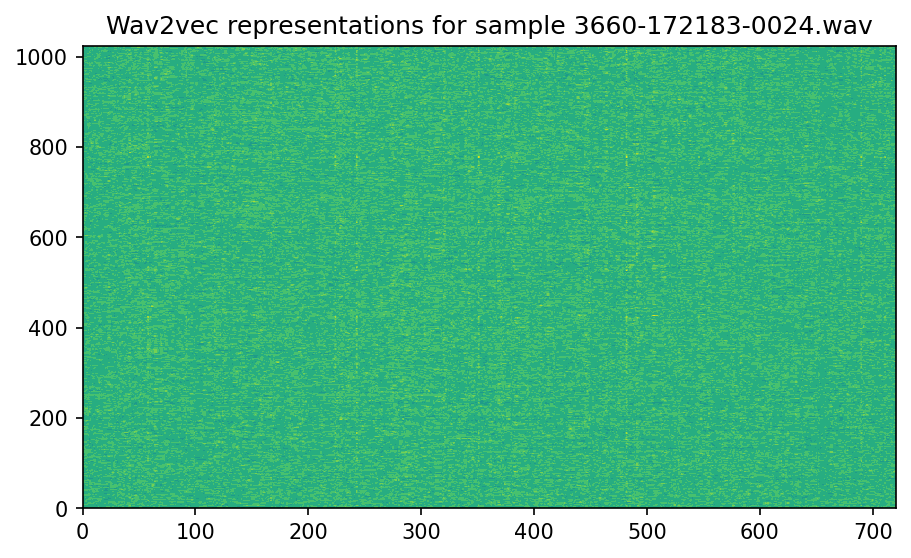

In [8]:
sample_idx = 1
x = np.arange(0, seq_lens[sample_idx])
y = np.arange(0, val_feats.shape[1])
X, Y = np.meshgrid(x, y)
Z = dataset[sample_idx].T
Z = Z / np.sqrt((Z**2).sum(1, keepdims=True))

plt.figure(figsize=(7, 4), dpi=150)
plt.contourf(X, Y, Z, 10)
plt.title(f"Wav2vec representations for sample {audio_ids[sample_idx]}")

In [35]:
cp = '/multirun/2023-04-27/06-48-15/0/w2v-indy-phn_en-phn_en_2023-04-27_06:48:00_1/checkpoint_last.pt'
# cp = '/home/santiago.cuervo/multirun/2023-04-21/12-39-26/0/w2v-indy-phn_en-phn_en_2023-04-21_12:39:04/checkpoint_last.pt'
# cp = '/home/santiago.cuervo/multirun/2023-03-29/20-23-26/0/w2v-indy-phn_en-phn_en_2023-03-29_20:22:27/checkpoint_last.pt'

model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp])
model = model[0]
model.eval()

LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 10.64M


Wav2vec_U(
  (segmenter): JoinSegmenter()
  (lm): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(40, 384)
      (wpe): Embedding(256, 384)
      (drop): Dropout(p=0.2, inplace=False)
      (h): ModuleList(
        (0-5): 6 x Block(
          (ln_1): LayerNorm()
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=384, out_features=1152, bias=False)
            (c_proj): Linear(in_features=384, out_features=384, bias=False)
            (attn_dropout): Dropout(p=0.2, inplace=False)
            (resid_dropout): Dropout(p=0.2, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLP(
            (c_fc): Linear(in_features=384, out_features=1536, bias=False)
            (c_proj): Linear(in_features=1536, out_features=384, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm()
    )
    (lm_head): Linear(in_features=384, out_features=40, bias=False)
  )
  (discriminat

In [36]:
entropies = []

# LM Posteriograms

Utterance:
AH N D DH OW DH AW SH OW L D AH S T D IH Z AY ER T UW S IY M AY D IH F IY T AH N D M AY D EH TH B AY DH AH HH AE N D Z AH V DH OW Z M EH N Y EH T D UW AY F IY L N OW D R EH D

Predicted:
<SIL> M AW TH W TH OY W IY DH EY W IY DH EY W IH DH EY HH AO EY W SH DH SH EY S HH UH DH EY DH EY W UH DH AE EH DH EY W UH IY DH HH SH IY W AO T AE T EH <SIL> IY HH EH HH EH HH EH SH <SIL> M AE T HH W OY W OY UH IY S IH UH DH AE EY W UH DH EY S W SH EY K AO T AE T DH EY EH HH EH HH EH SH <SIL> T <SIL> SH IY S HH IH DH T AE T HH EH EY EH <SIL> AE AW T TH EY K IH UH EY R IH N DH EY W SH IY S K AO UH DH AE T DH EY


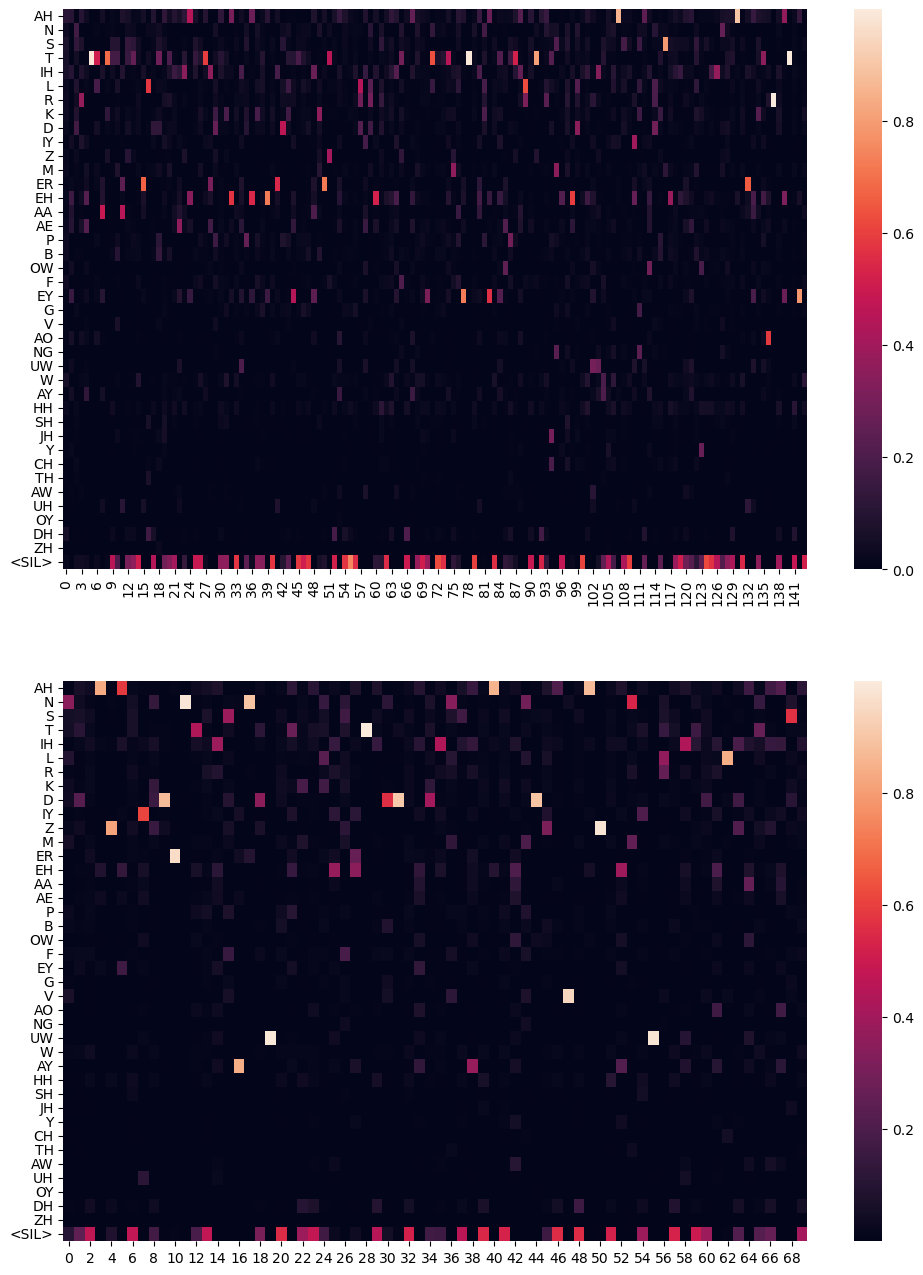

In [37]:
sample_idx = 0
x = torch.FloatTensor(dataset[sample_idx]).unsqueeze(0)
padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
gen_result = model(x, padding_mask, dense_x_only=True)
dense_x = gen_result['logits'][:, :, 4:]
y = model.lm(dense_x[:, :model.block_size, :]).squeeze()
# Getting encoded sample
token_x = task.target_dictionary.encode_line(phone_transcripts[sample_idx][:-1], append_eos=False).long() - 4
token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols) - 4).unsqueeze(0).float()
lm_post_true = model.lm(token_x[:, :model.block_size, :]).squeeze()
plt.figure(figsize=(12, 16))
plt.subplot(211)
sns.heatmap(lm_post_gen.detach().numpy().T, yticklabels=task.target_dictionary.symbols[4:])
plt.subplot(212)
sns.heatmap(lm_post_true.detach().numpy().T, yticklabels=task.target_dictionary.symbols[4:])
print(f"Utterance:\n{phone_transcripts[sample_idx]}")
print(f"Predicted:\n{task.target_dictionary.string(dense_x.argmax(-1) + 4)}")

# Evaluating a trained discriminator

In [ ]:
model.discriminator()

Utterance:
AH N D DH OW DH AW SH OW L D AH S T D IH Z AY ER T UW S IY M AY D IH F IY T AH N D M AY D EH TH B AY DH AH HH AE N D Z AH V DH OW Z M EH N Y EH T D UW AY F IY L N OW D R EH D

Predicted:
<SIL> M AW DH AW TH W EY DH W EY TH DH EY TH W OY DH Z TH W AA Z W EY TH W D DH EY TH W AA Z DH EY TH W AA Z R B AH B AH T W AA Z DH EY W IH Z TH R IH R T IH R IH T IH M AW TH W AW Z SH S R D SH UH D SH UH D EY W R AH B AH T EY TH W AA Z DH IH EY AH IH T Z IH EY IH EY TH R B AH T EY W AA Z AA Z T R IH T AH IH M AW TH W AW OY S Z W SH UH DH EY TH R EY AH D DH EY TH


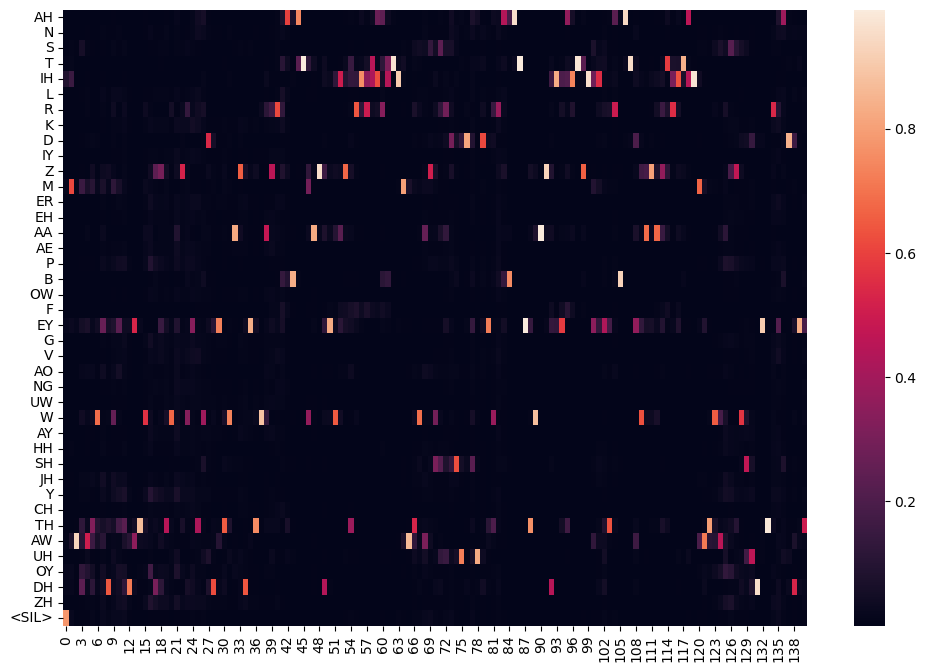

In [14]:
sample_idx = 0
x = torch.FloatTensor(dataset[sample_idx]).unsqueeze(0)
padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
gen_result = model(x, padding_mask, dense_x_only=True)
dense_x = gen_result['logits'][:, :, 4:].squeeze()
plt.figure(figsize=(12, 8))
sns.heatmap(dense_x.detach().numpy().T, yticklabels=task.target_dictionary.symbols[4:])
print(f"Utterance:\n{phone_transcripts[sample_idx]}")
print(f"Predicted:\n{task.target_dictionary.string(dense_x.argmax(-1) + 4)}")

Utterance:
AY G OW N AW L AO R D S EH D HH IY T UW M IY T DH AH N AY T AH N D T UW K AA N D AH K T HH IH M T UW HH IH Z L AA JH IH NG

Predicted:
R AH R AH R AH B AH D DH EY W AA Z EY Z W AA Z W F R IH Z IH T UH IH M AW TH R AW R B AH T AW TH W TH R AH B AH T M AW DH W AA EY TH W SH UH TH W R AH B AH T AA Z DH EY TH W AA Z EY W B AH T EY TH T IH F R AH IH T IH AW IH DH EY TH DH EY TH R AH B AH T W AA Z W Z DH EY AH B AH T IH AA Z EY Z R T IH R IH T IH M AW TH W AA Z W AA Z EY W EY DH EY R


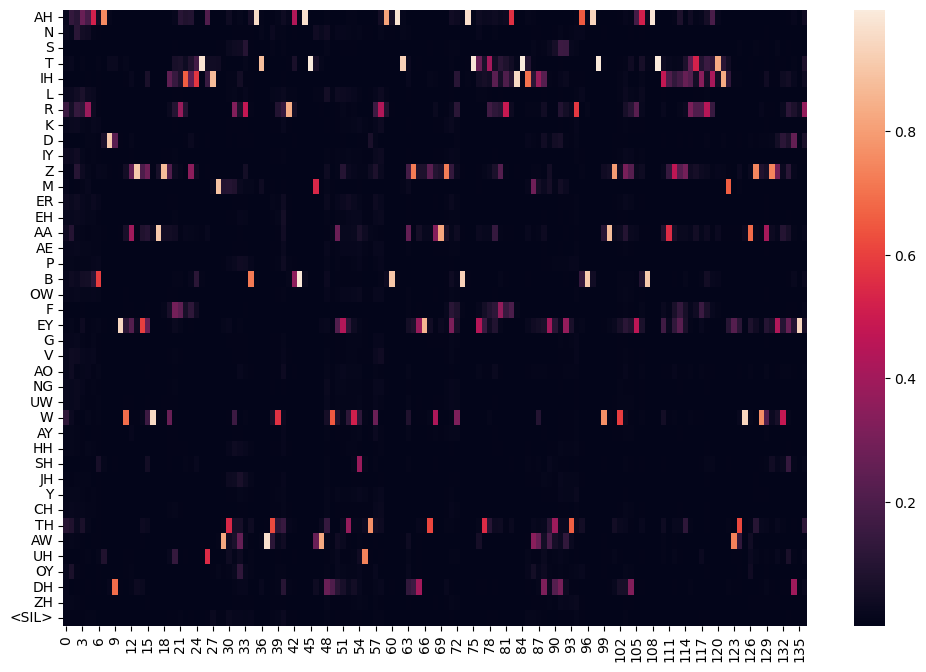

In [15]:
sample_idx = 1
x = torch.FloatTensor(dataset[sample_idx]).unsqueeze(0)
padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
gen_result = model(x, padding_mask, dense_x_only=True)
dense_x = gen_result['logits'][:, :, 4:].squeeze()
plt.figure(figsize=(12, 8))
sns.heatmap(dense_x.detach().numpy().T, yticklabels=task.target_dictionary.symbols[4:])
print(f"Utterance:\n{phone_transcripts[sample_idx]}")
print(f"Predicted:\n{task.target_dictionary.string(dense_x.argmax(-1) + 4)}")

Utterance:
AH N D HH IY R AH S IY V D HH IH M AH N D DH AE T N AA T F IY B L IY

Predicted:
R IH T IH T IH AW R IH B AH T AH B AH T M AW DH EY DH EY TH W EY Z SH DH EY SH UH D DH EY W AA Z W Z W AA Z TH R IH Z R F IH T B T AH <SIL> IH M AW TH S M S EY DH R TH R D R AH B AH T M AW M EY DH EY TH W AA Z AH W SH UH D W EY W EY W Z W EY DH EY TH W AA Z DH EY Z W B AH T W AA Z AH EY F W AA B AH T IH EY IH AA Z IH T


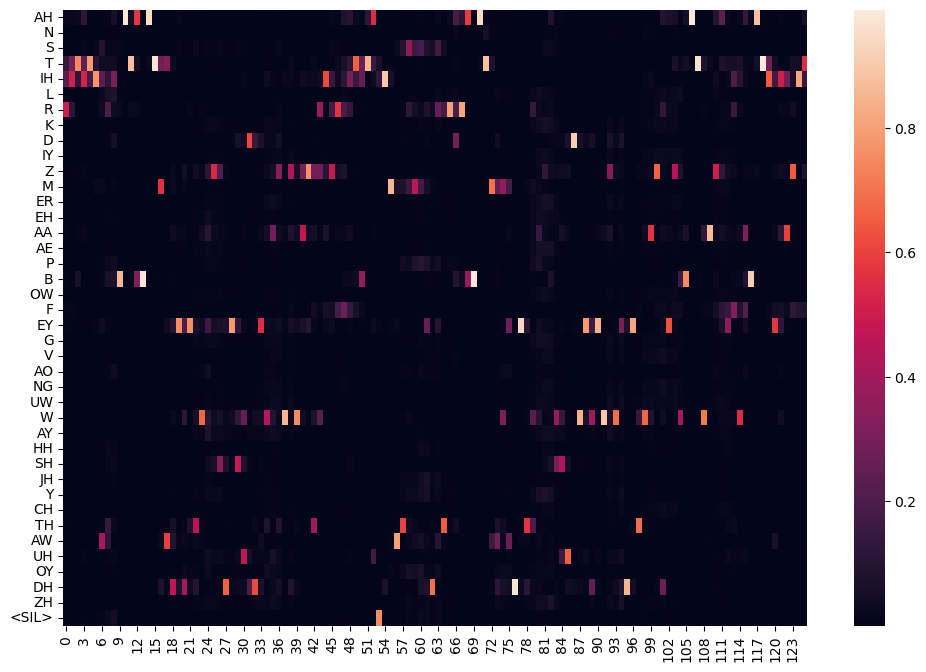

In [16]:
sample_idx = 2
x = torch.FloatTensor(dataset[sample_idx]).unsqueeze(0)
padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
gen_result = model(x, padding_mask, dense_x_only=True)
dense_x = gen_result['logits'][:, :, 4:].squeeze()
plt.figure(figsize=(12, 8))
sns.heatmap(dense_x.detach().numpy().T, yticklabels=task.target_dictionary.symbols[4:])
print(f"Utterance:\n{phone_transcripts[sample_idx]}")
print(f"Predicted:\n{task.target_dictionary.string(dense_x.argmax(-1) + 4)}")

0. L AW TH L AO TH AO TH AH DH AH DH AH AE TH AE EH DH AH IH DH P L IH DH IY DH AH P K DH IH P IH IY EY AE ZH CH Y P OW IH DH AE R AE AA IY B AE IH Y IH Y IH Y M Y L Y M <SIL> JH <SIL> TH AO L N D TH L TH L DH AE TH DH AH AE AH T DH AE R AE DH AE Y IY AE DH Y JH UH M Y M Y JH <SIL> Y AO TH AO TH AO Y TH L AE DH AE DH M DH M TH M Y M JH <SIL> TH AO TH AO TH DH AW TH DH AH L DH AH R DH AE DH AH DH

1. DH AE DH AE DH EH Y IH Y IH Y D IH M JH <SIL> TH L AE DH AE T TH DH AE M EH N AE R DH AE T AE T DH T IH DH T DH NG AE AH EY R AE DH AE IY T IH T IH OW DH IH DH IH UH F DH EY IH OW Y B JH Y M Y M JH <SIL> TH AO L N TH DH TH DH TH AE DH AE DH P R DH AE DH IH B Y DH AE B Y M Y M Y M Y JH <SIL> M L TH L AO JH DH AE DH Y HH L Y L M

2. DH M JH DH <SIL> TH N TH AE R DH AE T TH T AE DH AE P TH DH AE L AE IH TH IH L IH AH TH AH UH AE Y AH F HH IH Y M IH M AH M Y JH <SIL> L TH L TH D TH D L TH L AH AO AE AW DH L AO EH DH AE DH T TH Z IY IH DH AE L R DH IH AE DH IH DH IH AH OY IH F IH S IH AE IH AH I

27. AO L R TH AE DH AE DH T DH IH DH IH DH P DH AE DH AE JH Y AE Y M Y JH <SIL> L TH AO N TH AO TH Y <SIL> JH DH L TH AH B AH IH AE IH DH EH DH IH AE EH AE Y DH Y M Y M JH <SIL> N L AE TH L T DH L JH AE DH JH AE L AE M JH EH JH <SIL> AO TH AW TH L D L DH AH L D AH DH AH IH DH AH IH S DH EH IH AH DH EH F DH AH AE AH AE DH G AE DH IY P B DH P IH P Y IH IY AE TH UH Y M Y

28. M JH <SIL> AO L TH N TH AE TH DH L DH AH L DH IH DH AE Y JH TH M JH <SIL> TH AO D TH AO TH D AW AH N DH AE N R AO D DH AE DH R AE R AE DH AE DH

29. AE R DH AE DH AE T L DH AE DH IH AH AW R AE AH AA R DH AE T DH NG DH T NG DH IH M P EH IH ZH IH DH OW NG M DH HH IH HH Y HH M Y JH <SIL> L TH N AW D AO TH DH N L DH TH DH AE EH AO IH DH AH AE AH DH JH DH R DH R AE DH R AE DH AE DH AE AO M OW Y IH DH B IH M B M Y M Y JH <SIL> TH AO

30. N AO N AO TH AE DH N TH L AE TH M TH DH JH TH IH M L DH F R AE DH AE DH Y M JH <SIL> TH L M L TH L TH IH DH <SIL> DH B AE AH DH M Y M AO JH <SIL> AO TH AO TH AW N L AE DH AE T TH AE TH D A

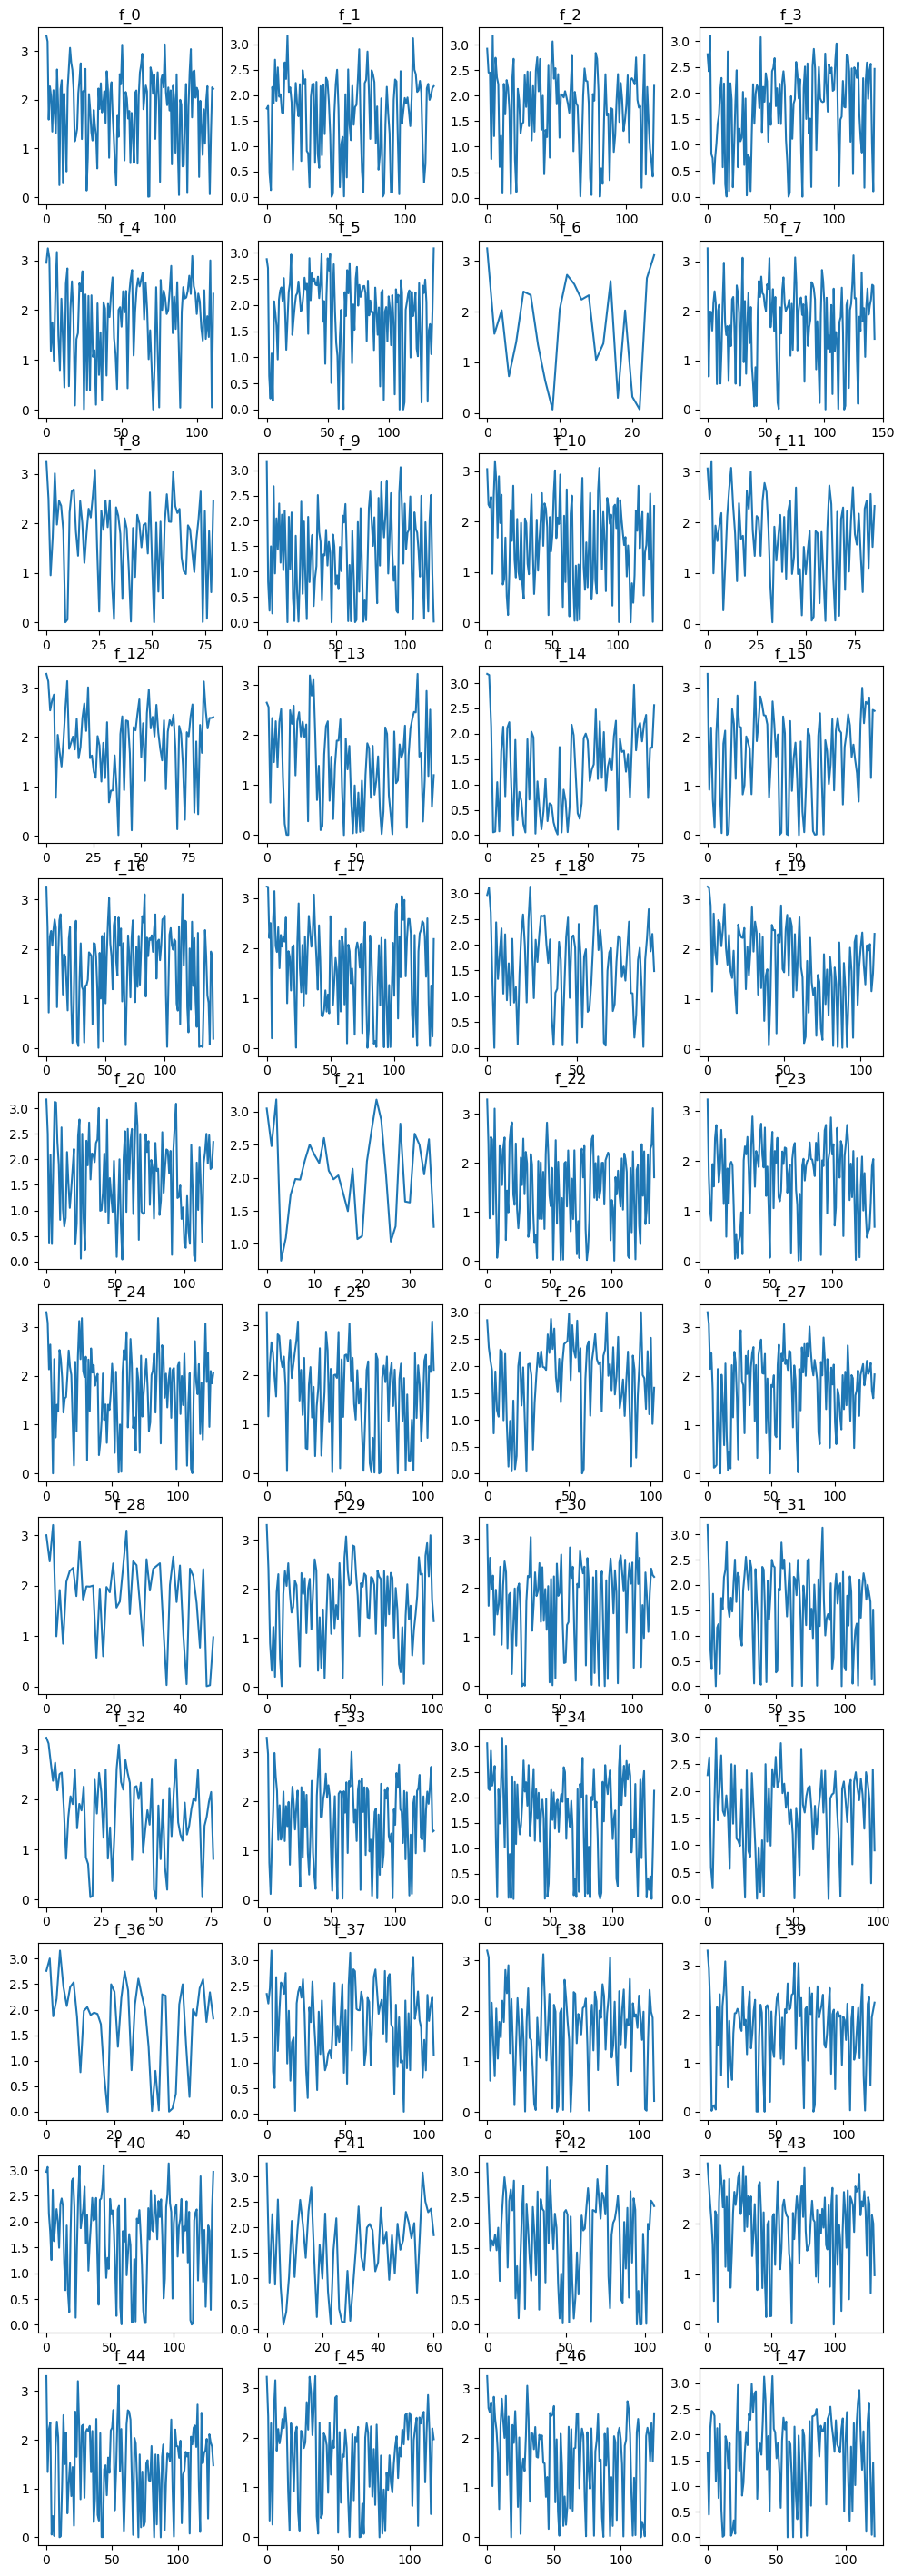

In [17]:
n_samples = 48
n_cols = 4
n_rows = math.ceil(n_samples / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
for sample_idx in range(n_samples):
    row = sample_idx // 4
    col = sample_idx % 4
    x = torch.FloatTensor(dataset[sample_idx]).unsqueeze(0)
    padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
#     print(x.size(), padding_mask.size())
    gen_result = model(x, padding_mask, dense_x_only=True)
    dense_x = gen_result['logits'][:, :, 4:]
    entropy_gen = model.lm(dense_x[:, :model.block_size, :]).squeeze().detach().numpy()
    for i, h in enumerate(entropy_gen):
        entropies.append({
            "type": "gen",
            "pos": i,
            "h": h
        })
    axs[row, col].plot(entropy_gen)
    axs[row, col].set_title(f"f_{sample_idx}")
    print(f"{sample_idx}. {task.target_dictionary.string(dense_x.argmax(-1) + 4)}\n")

In [11]:
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-txt/phones/lm.phones.filtered.txt", "r") as f:
    phone_transcripts = f.readlines()

In [12]:
phone_transcripts[:5]

['<SIL> JH EH N ER AH L P L EH Z AH N T AH N K AH M AE N D IH NG DH AH K AE V AH L R IY W AA Z S EH N T W IH DH HH IH Z IH N T AY ER F AO R S T UW L UH K IH N T UW DH AH M AE T ER <SIL>\n',
 '<SIL> W EH R EH V ER DH AH T IY CH ER L UH K S HH IY S IY Z DH AE T IH G Z AE M AH N EY SH AH N Z AA R <SIL> HH EH L D IH N HH AY HH AH N ER <SIL> AH N D <SIL> DH AE T DH AH M EY N B IH Z N AH S AH V <SIL> T IY CH ER Z AH V <SIL> AO L G R EY D Z IH Z T UW P R OW D UW S R IH Z AH L T S <SIL> W IH CH <SIL> AE N <SIL> AW T S AY D IH G Z AE M AH N ER W UH D <SIL> AE K S EH P T AE Z <SIL> S AE T AH S F AE K T R IY <SIL> AH N D HH IY <SIL> N AE CH ER AH L IY <SIL> T EY K S F AO R <SIL> G R AE N T AH D DH AE T DH AH P R AH D AH K SH AH N <SIL> AH V S AH CH R IH Z AH L T S IH Z DH AH T R UW F AH NG K SH AH N AH V <SIL> DH AH T IY CH ER <SIL> W EH DH ER <SIL> HH IH Z S AH K S EH S IH N P R AH D UW S IH NG <SIL> DH EH M IH Z T UW B IY T EH S T AH D B AY AH F AO R M AH L <SIL> IH G Z AE M AH N EY SH AH N <SI

In [13]:
token_x.size()

NameError: name 'token_x' is not defined

In [14]:
phone_transcripts[sample_idx].replace('\n', '')

'<SIL> W EH R EH V ER DH AH T IY CH ER L UH K S HH IY S IY Z DH AE T IH G Z AE M AH N EY SH AH N Z AA R <SIL> HH EH L D IH N HH AY HH AH N ER <SIL> AH N D <SIL> DH AE T DH AH M EY N B IH Z N AH S AH V <SIL> T IY CH ER Z AH V <SIL> AO L G R EY D Z IH Z T UW P R OW D UW S R IH Z AH L T S <SIL> W IH CH <SIL> AE N <SIL> AW T S AY D IH G Z AE M AH N ER W UH D <SIL> AE K S EH P T AE Z <SIL> S AE T AH S F AE K T R IY <SIL> AH N D HH IY <SIL> N AE CH ER AH L IY <SIL> T EY K S F AO R <SIL> G R AE N T AH D DH AE T DH AH P R AH D AH K SH AH N <SIL> AH V S AH CH R IH Z AH L T S IH Z DH AH T R UW F AH NG K SH AH N AH V <SIL> DH AH T IY CH ER <SIL> W EH DH ER <SIL> HH IH Z S AH K S EH S IH N P R AH D UW S IH NG <SIL> DH EH M IH Z T UW B IY T EH S T AH D B AY AH F AO R M AH L <SIL> IH G Z AE M AH N EY SH AH N <SIL> AO R N AA T <SIL>'

0. <SIL> JH EH N ER AH L P L EH Z AH N T AH N K AH M AE N D IH NG DH AH K AE V AH L R IY W AA Z S EH N T W IH DH HH IH Z IH N T AY ER F AO R S T UW L UH K IH N T UW DH AH M AE T ER <SIL>


1. <SIL> W EH R EH V ER DH AH T IY CH ER L UH K S HH IY S IY Z DH AE T IH G Z AE M AH N EY SH AH N Z AA R <SIL> HH EH L D IH N HH AY HH AH N ER <SIL> AH N D <SIL> DH AE T DH AH M EY N B IH Z N AH S AH V <SIL> T IY CH ER Z AH V <SIL> AO L G R EY D Z IH Z T UW P R OW D UW S R IH Z AH L T S <SIL> W IH CH <SIL> AE N <SIL> AW T S AY D IH G Z AE M AH N ER W UH D <SIL> AE K S EH P T AE Z <SIL> S AE T AH S F AE K T R IY <SIL> AH N D HH IY <SIL> N AE CH ER AH L IY <SIL> T EY K S F AO R <SIL> G R AE N T AH D DH AE T DH AH P R AH D AH K SH AH N <SIL> AH V S AH CH R IH Z AH L T S IH Z DH AH T R UW F AH NG K SH AH N AH V <SIL> DH AH T IY CH ER <SIL> W EH DH ER <SIL> HH IH Z S AH K S EH S IH N P R AH D UW S IH NG <SIL> DH EH M IH Z T UW B IY T EH S T AH D B AY AH F AO R M AH L <SIL> IH G Z AE M AH N EY SH AH N <SI

35. <SIL> AE M P L IY F ER N IH SH T W IH DH AO L DH AH N OW B L ER B EH N AH F IH T S <SIL> AH V W EH L TH <SIL> W IH DH <SIL> EH K S T R AH M IY N Z AH V <SIL> HH EH L TH AH V IH N T AH L EH K CH UW AH L <SIL> K AH L CH ER <SIL> AH N D <SIL> AH V <SIL> EH L AH G AH N T EH N JH OY M AH N T AA N <SIL> DH AH AH DH ER HH AE N D <SIL> W IY <SIL> N UW N AH TH IH NG AH V IH T S <SIL> S OW SH AH L D IH S T IH NG K SH AH N Z <SIL>


36. <SIL> S T IH L AH N AH M B ER HH AE D R IH CH M AH N D F ER M L IY F IH K S T IH N <SIL> DH EH R M AY N D Z <SIL>


37. <SIL> K AW P ER IH K S P R EH S T DH AH <SIL> S EY M S EH N T AH M AH N T T UW <SIL> AH F R EH N D N EY CH ER G IH V Z M EH N AH B AY AH S T UW DH EH R R IH S P EH K T IH V P ER S UW T S AH N D DH AE T S T R AO NG P R AH P EH N S IH T IY AY S AH P OW Z IH Z <SIL> W AH T W IY M IY N B AY JH IY N Y AH S <SIL>


38. <SIL> HH IH Z AY Z AA R K IY N T UW P IH R S <SIL> D IH S G AY Z IH Z <SIL>


39. <SIL> JH IY Z AH S <SIL> AE N S ER D AH N D <SIL>

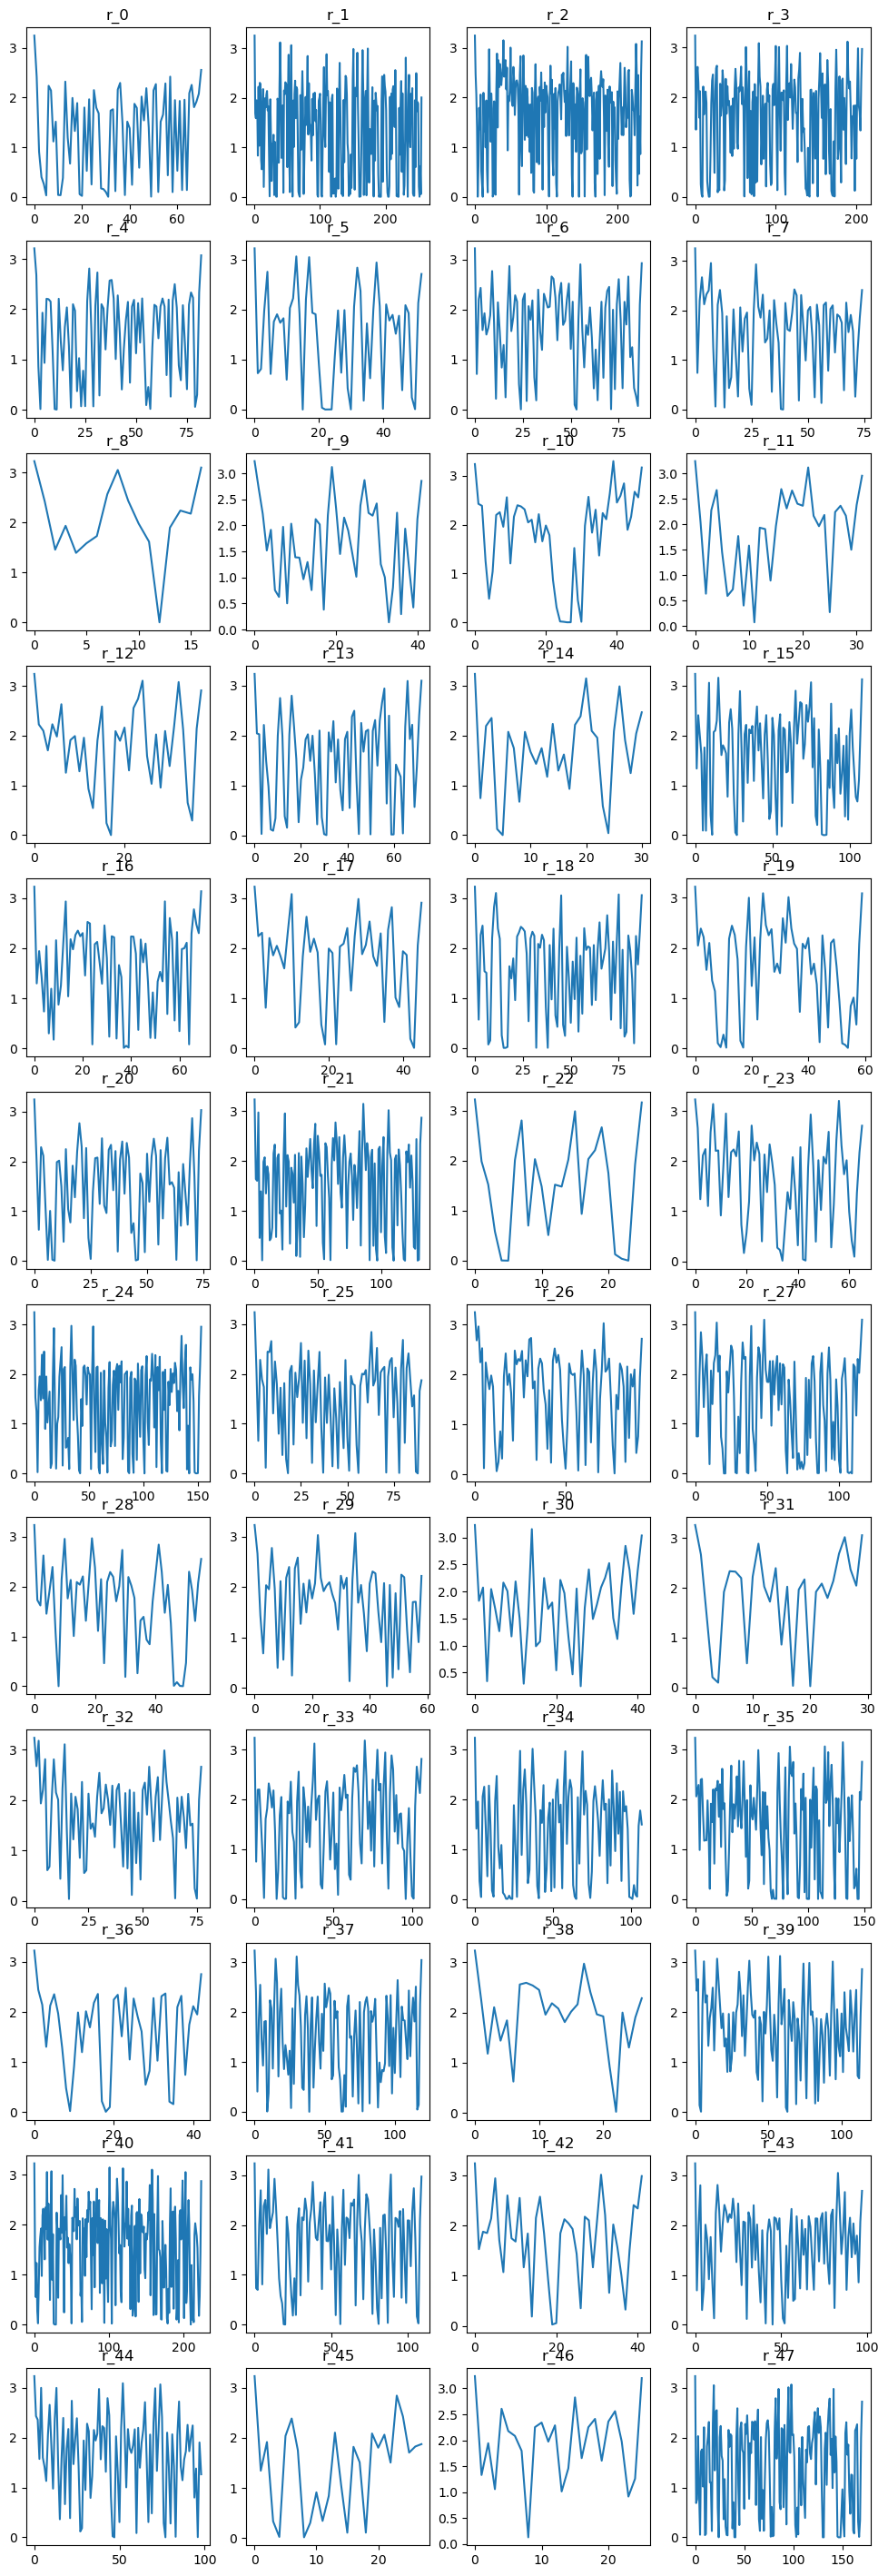

In [33]:
import math

n_samples = 48
n_cols = 4
n_rows = math.ceil(n_samples / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
for sample_idx in range(n_samples):
    row = sample_idx // 4
    col = sample_idx % 4
#     if len(phone_transcripts[sample_idx]) < model.block_size:
#         continue
    token_x = (task.target_dictionary.encode_line(phone_transcripts[sample_idx]).long() - 4)[:-1]
#     print(token_x, token_x.size())
    token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols) - 4).unsqueeze(0).float()
    entropy_true = model.lm(token_x[:, :model.block_size, :]).squeeze().detach().numpy()
    for i, h in enumerate(entropy_true):
        entropies.append({
            "type": "true",
            "pos": i,
            "h": h
        })
    axs[row, col].plot(entropy_true)
    axs[row, col].set_title(f"r_{sample_idx}")
    print(f"{sample_idx}. {phone_transcripts[sample_idx]}\n")

In [34]:
entropies = pd.DataFrame(entropies)
entropies.to_csv("dyn_entropies.csv")

In [35]:
entropies.head()

,type,pos,h
0,gen,0,3.313232
1,gen,1,3.191221
2,gen,2,1.589947
3,gen,3,2.271666
4,gen,4,2.062601


In [36]:
entropies.pos.describe(percentiles=[.25, .5, .75, .9, .95])

count    9455.000000
mean       59.504178
std        44.282689
min         0.000000
25%        24.000000
50%        52.000000
75%        86.000000
90%       116.000000
95%       135.000000
max       255.000000
Name: pos, dtype: float64

In [37]:
entropies.pos.quantile()

52.0

<AxesSubplot: xlabel='pos', ylabel='Count'>

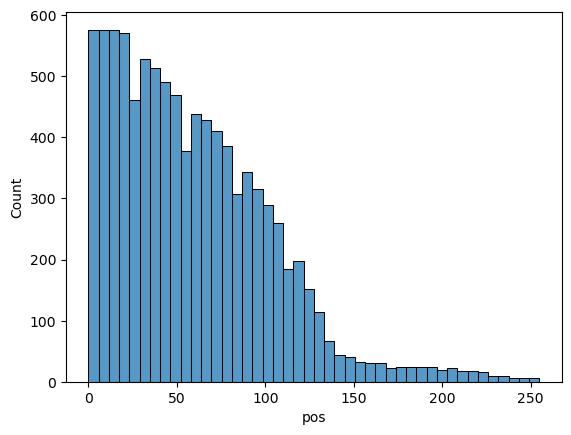

In [38]:
sns.histplot(entropies.pos)

In [39]:
entropies = entropies[entropies.pos <= 136]

In [40]:
entropies.groupby(["type", "pos"]).describe()

h                                                              \
         count      mean       std       min       25%       50%       75%   
type pos                                                                     
gen  0    48.0  3.050076  0.370765  1.653212  2.964507  3.195229  3.265351   
     1    48.0  2.360772  0.752029  0.443015  2.161714  2.468687  3.017334   
     2    48.0  1.836431  0.891645  0.232080  0.885159  2.138090  2.449616   
     3    48.0  1.596344  0.921621  0.019400  0.799402  1.860700  2.355410   
     4    48.0  1.530319  0.912573  0.002247  0.931248  1.585589  2.231927   
...        ...       ...       ...       ...       ...       ...       ...   
true 132   8.0  1.501230  0.855947  0.176878  0.985054  1.448195  1.924874   
     133   7.0  1.230557  0.831257  0.057787  0.594301  1.366242  1.951300   
     134   7.0  1.214629  0.823699  0.015270  0.724861  1.302436  1.713464   
     135   7.0  1.576075  1.171214  0.000502  0.693388  1.976531  2.450142   
     136   7.0  1.418461  0.903914  0.161623  0.688632  1.839241  1.998174   

                    
               max  
type pos            
gen  0    3.313232  
     1    3.242739  
     2    3.209689  
     3    3.184003  
     4    3.174499  
...            ...  
true 132  2.864207  
     133  2.098667  
     134  2.308047  
     135  2.768431  
     136  2.554753  

[274 rows x 8 columns]

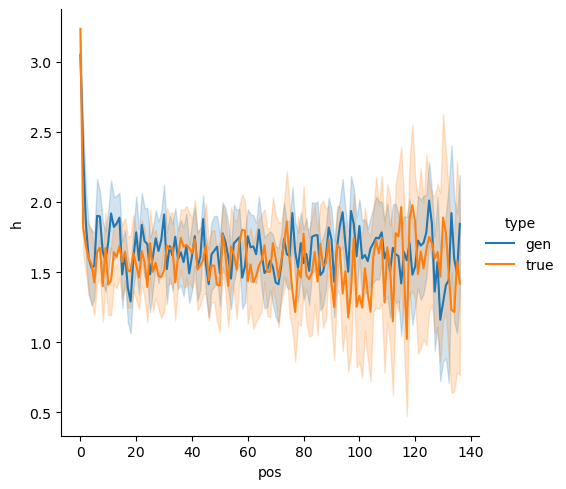

In [41]:
g = sns.relplot(data=entropies, x="pos", y="h", hue="type", kind="line", estimator=np.mean)

In [16]:
sample_idx = 0
start = " ".join(phone_transcripts[sample_idx].split()[:10])
print(start)
start = (task.target_dictionary.encode_line(start).long() - 4)[:-1]
print(start)
x = start[None, ...]
ctx = torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16)
# run generation
max_new_tokens = 256 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 5
with torch.no_grad():
    with ctx:
        for k in range(3):
            y = model.lm.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(task.target_dictionary.string(y[0] + 4))
            print('---------------')

<SIL> JH EH N ER AH L P L EH
tensor([39, 30, 13,  1, 12,  0,  5, 16,  5, 13])
<SIL> JH EH N ER AH L P L EH JH IH T <SIL> IH Z AH <SIL> S IH T AH Z AH N AH V S T IY V AH N <SIL> K R IH S T AH F ER <SIL> K AE N AH S <SIL> AH N D <SIL> S T IY V AH N <SIL> K R IH S T AH F ER <SIL> K AE N AH S <SIL> HH UW Z <SIL> S T IY V AH N <SIL> K R IH S T AH F ER <SIL> K AE N AH S <SIL> W AA Z <SIL> AH <SIL> S IH T AH Z AH N <SIL> AH V <SIL> K R IH S T AH F ER <SIL> K AE N AH S <SIL> W IH CH <SIL> HH IY <SIL> W AA Z AH M EH M B ER AH V <SIL> DH AH S T EY T <SIL> S EH N AH T <SIL> F R AH M <SIL> W AH N EY T <SIL> N AY N <SIL> S EH V AH N <SIL> T UW <SIL> W AH N N AY N <SIL> W AH N EY T <SIL> HH IY <SIL> W AA Z AH P OY N T AH D <SIL> AE Z AH P R EH Z AH D EH N T <SIL> F AO R <SIL> R EH P R AH Z EH N T AH T IH V <SIL> K R IH S T AH F ER <SIL> K AE TH ER IH N AH N D <SIL>
---------------
<SIL> JH EH N ER AH L P L EH JH D <SIL> DH AE T <SIL> DH AH <SIL> K AH M IH SH AH N ER <SIL> W AA Z <SIL> IH N S T AO L 

In [ ]:
phone_transcripts[sample_idx]

In [17]:
task.target_dictionary.symbols

['<s>',
 '<pad>',
 '</s>',
 '<unk>',
 'AH',
 'N',
 'S',
 'T',
 'IH',
 'L',
 'R',
 'K',
 'D',
 'IY',
 'Z',
 'M',
 'ER',
 'EH',
 'AA',
 'AE',
 'P',
 'B',
 'OW',
 'F',
 'EY',
 'G',
 'V',
 'AO',
 'NG',
 'UW',
 'W',
 'AY',
 'HH',
 'SH',
 'JH',
 'Y',
 'CH',
 'TH',
 'AW',
 'UH',
 'OY',
 'DH',
 'ZH',
 '<SIL>']

In [36]:
task.target_dictionary.encode_line(phone_transcripts[0])

tensor([ 4,  5, 12, 41, 22, 41, 38, 33, 22,  9, 12,  4,  6,  7, 12,  8, 14, 31,
        16,  7, 29,  6, 13, 15, 31, 12,  8, 23, 13,  7,  4,  5, 12, 15, 31, 12,
        17, 37, 21, 31, 41,  4, 32, 19,  5, 12, 14,  4, 26, 41, 22, 14, 15, 17,
         5, 35, 17,  7, 12, 29, 31, 23, 13,  9,  5, 22, 12, 10, 17, 12,  2],
       dtype=torch.int32)

In [25]:
task.target_dictionary.string(dense_x.argmax(-1))

'AE IY AE IH IY UW AW AO TH IH <unk> IH IY UW TH AO TH <unk> TH AW TH <pad> TH <pad> TH <pad> TH AW <pad> <unk> <pad> AW <pad> DH AE AH DH AH DH AH DH AE AH <pad> AE AH AE DH AE DH JH R AH DH AH DH R DH AE ZH AE DH AH DH AO AE DH IH S ZH OW IH S OW IH F AE EH W EH'

In [21]:
dense_x.argmax(-1)

tensor([[19, 13, 19,  8, 13, 29, 38, 27, 37,  8,  3,  8, 13, 29, 37, 27, 37,  3,
         37, 38, 37,  1, 37,  1, 37,  1, 37, 38,  1,  3,  1, 38,  1, 41, 19,  4,
         41,  4, 41,  4, 41, 19,  4,  1, 19,  4, 19, 41, 19, 41, 34, 10,  4, 41,
          4, 41, 10, 41, 19, 42, 19, 41,  4, 41, 27, 19, 41,  8,  6, 42, 22,  8,
          6, 22,  8, 23, 19, 17, 30, 17]])

In [9]:
gen_result = model.generator(x, None, padding_mask)
print(gen_result.keys())

dict_keys(['inter_x', 'log_probs', 'pred_log_probs', 'dense_x', 'token_x', 'dense_padding_mask'])


In [10]:
boundary_probs = gen_result["log_probs"][:, :, 1].view(-1).exp()

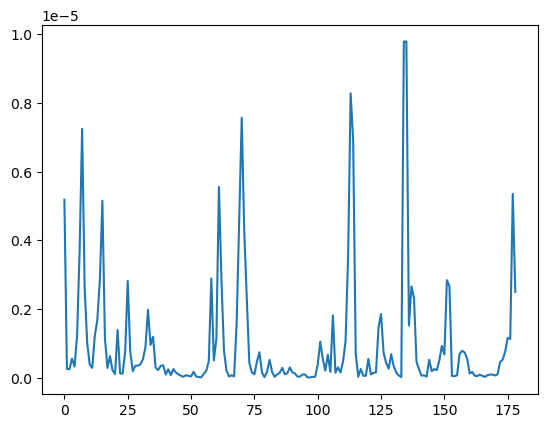

In [11]:
plt.plot(boundary_probs.detach().numpy())

In [12]:
boundary_probs[0]

tensor(5.1874e-06, grad_fn=<SelectBackward0>)

In [13]:
sample_len = 8
AVG_PHONE_DURATION = 3.790364
all_segments_len_sample_probs = F.unfold(gen_result["log_probs"].view(-1, 2)[:, 1].exp().view(1, 1, -1, 1), (sample_len, 1))
expected_num_boundaries = all_segments_len_sample_probs.sum(1)
len_prior_loss = (expected_num_boundaries.mean() - (sample_len / AVG_PHONE_DURATION))**2
len_prior_loss

tensor(4.4547, grad_fn=<PowBackward0>)

In [14]:
!ls /home/santiago.cuervo/ssl/mywav2vec/multirun/2023-01-15/11-46-31/0/checkpoint_best.pt

ls: cannot access '/home/santiago.cuervo/ssl/mywav2vec/multirun/2023-01-15/11-46-31/0/checkpoint_best.pt': No such file or directory


In [15]:
pred_probs = gen_result["pred_log_probs"].view(-1).exp()

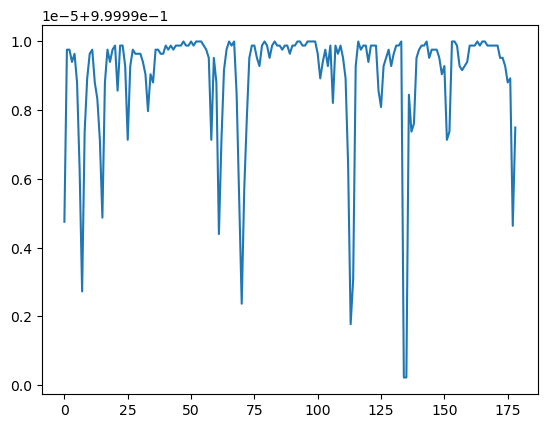

In [16]:
plt.plot(pred_probs.detach().numpy())

In [17]:
foo = "g g er er hh aa aa f f g er z ae z z z z hh ae ae er z z f th aw hh hh hh ae ae f ae ae ae g z z p er aa ae ae ng hh hh er ae ae ae er ae ae ae hh hh hh hh er aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw"
foo = foo.split(' ')

In [18]:
len(foo)

207

In [19]:
phone_transcripts[-100:]

['B AH T HH IY D B IH N T UW S IH K AH N D T UW L AO NG AH B EH D\n',
 'AA N DH AH M IH D AH L AH V HH IH Z B AE K N EH L T M AY W AH N AA R M D F R EH N D\n',
 'DH EH N AH G EH N HH IY D S IH NG DH AE T B AA R B ER IY S AO NG AH N T IH L AY D G OW AW T AH N D L UH K AE T DH AH OW L D K AA L ER AA D OW F L OW IH NG B AY JH AH S T T UW B IY SH UH R AY HH AE D AH N T D AY D AH N D G AO N B IH L OW AO R EH L S HH IY D JH AH S T T AO K\n',
 'HH IY D IH D S OW N AW F AY ER AH W EY S EH D AY\n',
 'DH AH M EH K S W AA Z F L AE T AA N HH IH Z F EY S HH IH Z AA R M Z S T R EH CH T AW T\n',
 'AY Y UW Z D T UW L IH S AH N B AY DH AH AW ER B AH T AY N EH V ER M EY D AW T EH N IY TH IH NG R IH L IY IH M P AO R T AH N T AE Z T UW HH UW DH AH M AE N W AA Z AO R W EH R HH IY D K AH M F R AH M AO R W AH T HH IY D D AH N\n',
 'W EH R Z M AY K OW T HH IY AE S K T\n',
 'W IY T AO K T DH AH M AE T ER OW V ER AE T L EH NG K TH\n',
 'AY R AE N AH P P UH L IH NG M AY G AH N\n',
 'W AY M EY T HH IY AE N S ER D